# 시계열 데이터와 정상성

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas_datareader.data as web
import numpy as np

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore') 

path = 'D:/drive/Obsidian/Fonts/나눔손글씨 성실체.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)
pd.set_option('display.max_columns', None)

In [3]:
sns.set_style('whitegrid')

## 시계열 데이터 다운로드

산업 생산 월간 데이터와 NASDAQ 주식 시장 지수 일간 데이터를 로드합니다.:

In [4]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

## 시계열 요소 분해 (additive decomposition)

시계열데이터는 일반적으로 다양한 패턴이 혼합되어 있으며, 이는 각각 기본 패턴 범주를 나타내는 여러 구성 요소로 분해될 수 있습니다. 특히 시계열은 체계적인 구성 요소인 **추세, 계절성 및 주기**와 **체계적이지 않은 노이즈**로 구성됩니다. 구성 요소는 자동으로 분할할 수 있습니다.

 statsmodels에는 이동 평균을 사용하여 시계열을 추세, 계절적, 잔차 구성 요소로 분할하는 간단한 방법이 포함되어 있습니다. 다음과 같이 강력한 추세와 계절성 구성 요소가 있는 산업 제조 생산에 대한 월간 데이터에 적용할 수 있습니다.

In [5]:
components = tsa.seasonal_decompose(industrial_production, model='additive') # 시계열로 분해하는 

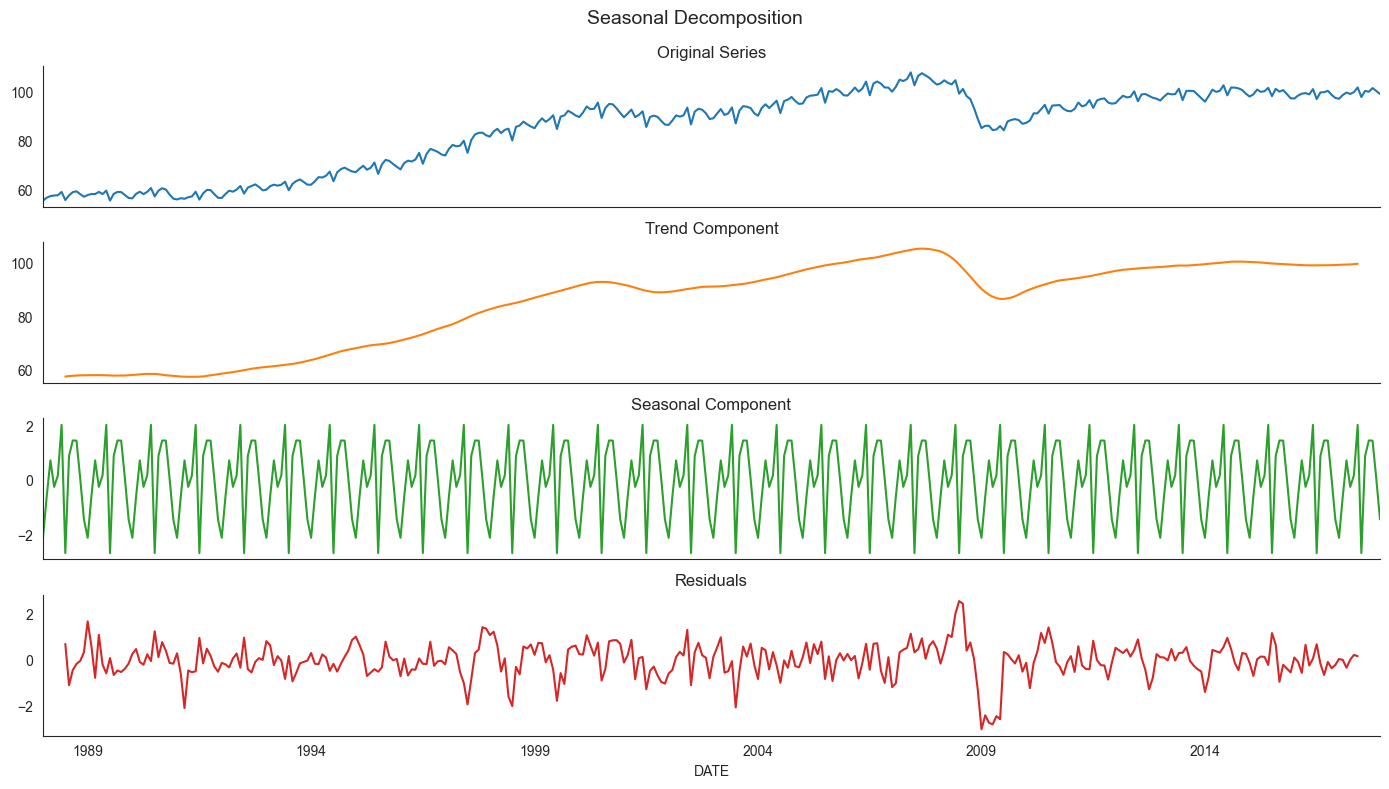

In [6]:
ts = (industrial_production.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

## 시계열 정상성(Time Series Stationarity)

평균, 분산 또는 자기 상관과 같은 정상 시계열의 통계적 특성은 기간과 무관하며, 즉 시간이 지남에 따라 변하지 않습니다. 따라서 **정상성은 시계열에 추세나 계절적 효과가 없고, 평균이나 표준 편차와 같은 기술 통계가 서로 다른 이동 창에 대해 계산될 때 일정하거나 시간이 지남에 따라 크게 변하지 않는다는 것을 의미**합니다. 평균으로 회귀되고 편차의 진폭이 일정하며, 단기적 움직임은 통계적 의미에서 항상 동일하게 보입니다.


보다 공식적으로, 엄격한 정상성은 시계열 관측치의 **모든 하위 집합의 결합 분포가 모든 모멘트에 대해 시간과 무관해야** 합니다. 따라서 평균과 분산 외에도 왜도와 첨도와 같은 더 높은 모멘트도 서로 다른 관측치 간의 지연과 무관하게 일정해야 합니다. 대부분의 응용 분야에서 **정상성을 1차 및 2차 모멘트로 제한하여 시계열이 평균, 분산 및 자기 상관이 일정한 공분산 정상성**이 됩니다.




선형 회귀의 입력 데이터가 결과와 상관관계가 있어야 하는 것처럼 서로 다른 지연에서 관측치 간의 종속성을 특별히 허용한다는 점에 유의하세요. 정상성은 이러한 관계가 안정적임을 의미하며, 이는 모델이 안정적인 통계적 특성 내에서 발생하는 체계적인 패턴을 학습하는 데 집중할 수 있으므로 예측을 용이하게 합니다. 고전적 통계 모델은 시계열 입력 데이터가 정상적이라고 가정하기 때문에 중요합니다.


선형 시계열 모델의 정상성 가정을 충족하려면 종종 여러 단계로 원래 시계열을 변환해야 합니다. 일반적인 변환에는 지수적 성장 패턴을 선형적 추세로 변환하고 분산을 안정화하기 위해 (자연) 로그를 적용하는 것이 포함됩니다. 디플레이션은 추세적 행동을 일으키는 다른 시계열로 시계열을 나누는 것을 의미하며, 예를 들어 명목 시계열을 가격 지수로 나누어 실제 측정값으로 변환하는 것입니다.

> 정상성의 유형



- 엄격 정상성: 시계열의 모든 통계적 특성이 모든 시간 지연에 대해 동일합니다.
- 약한 정상성: 시계열의 평균, 분산, 자기 상관이 시간에 따라 일정합니다.

> 정상성의 중요성


- 정상성은 시계열 모델링에 중요합니다. 대부분의 통계적 시계열 모델은 정상적인 입력 데이터를 가정합니다. 
- 정상성이 없으면 모델이 잘못된 예측을 생성할 수 있습니다.


> 정상성 검정


시계열의 정상성을 검정하는 데 사용할 수 있는 여러 가지 통계 검정이 있습니다. 일반적인 검정에는 다음이 포함됩니다.
- ADF 검정: 단위 근 검정으로 시계열에 단위 근이 있는지 여부를 검정합니다.
- KPSS 검정: 정상성 검정으로 시계열이 정상적인지 여부를 검정합니다.
- 자기 상관 함수(ACF) 및 편자기 상관 함수(PACF) 플롯: 시계열의 자기 상관 구조를 시각화하는 데 사용할 수 있으며 정상성을 평가하는 데 도움이 될 수 있습니다.

> 정상성 변환


시계열이 정상적이지 않은 경우 정상성을 유도하기 위해 데이터를 변환할 수 있습니다. 일반적인 변환에는 다음이 포함됩니다.



- 로그 변환: 지수적 성장 패턴을 선형적 추세로 변환하는 데 사용됩니다.
- 차분: 시계열의 차이를 계산하여 추세를 제거하는 데 사용됩니다.
- 계절 차분: 시계열의 계절적 성분을 제거하는 데 사용됩니다.

### 로그변환

로그 변환 전, 각 값에 0이 없는지 확인

In [7]:
(nasdaq == 0).any(), (industrial_production==0).any()

(False, False)

In [8]:
'로그변환'
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

### 차분(Differencing)

많은 경우 추세 제거만으로는 시계열을 정상적으로 만들기에 충분하지 않습니다. 대신 원래 데이터를 기간 간 및/또는 계절 간 차이 시계열로 변환해야 합니다. 즉, 인접한 데이터 포인트 또는 계절적 지연에서의 값을 서로 뺍니다. 이러한 차분이 로그 변환된 시계열에 적용될 때 결과는 금융적 맥락에서 순간적인 성장률 또는 수익률을 나타낸다는 점에 유의하세요.<br>


단변량 시계열이 d번 차분한 후 정상적이 되면 d차 적분이라고 하며, d=1이면 단순히 적분이라고 합니다. 이러한 행동은 단위 근 때문입니다.<br>


로그 시계열의 차분은 순간적인 수익률을 생성합니다.<br>

In [9]:
nasdaq_log_diff = nasdaq_log.diff().dropna()

# 계절적 차분 => 연간 순간적 수익률
'''
계절적 차분은 시계열 데이터에서 계절적 패턴을 제거하는 데 사용되는 차분 유형입니다. 
계절적 차분은 데이터에서 같은 계절(예: 매년 같은 달)의 값을 뺍니다.
계절적 차분이 로그 변환된 시계열에 적용되면 결과는 연간 순간적 수익률을 나타냅니다. 
연간 순간적 수익률은 한 해의 특정 기간과 이전 해의 같은 기간의 로그 가격 차이입니다.

예를 들어, 월간 로그 가격 시계열이 있다고 가정해 보겠습니다. 

계절적 차분을 적용하면 연간 순간적 수익률 시계열이 생성됩니다. 
이 시계열은 각 달의 로그 가격과 이전 해 같은 달의 로그 가격의 차이로 구성됩니다
연간 순간적 수익률은 금융 시장에서 자산의 수익률을 측정하는 데 자주 사용됩니다. 
연간 순간적 수익률은 자산의 성과를 평가하고 투자 결정을 내리는 데 사용할 수 있습니다.
'''

industrial_production_log_diff = industrial_production_log.diff(12).dropna()

### Plot Series

다음 차트는 2017년까지 30년 동안의 NASDAQ 주가 지수와 산업 생산에 대한 시계열을 원래 형태와 로그를 적용한 후 변환된 버전과 그 후에 각각 1차 차분과 계절적 차분(지연 12)을 적용한 버전을 보여줍니다. 이 차트는 또한 ADF p값을 표시하는데, 이를 통해 두 경우 모두 모든 변환 후 단위 근 비정상성 가설을 기각할 수 있습니다.


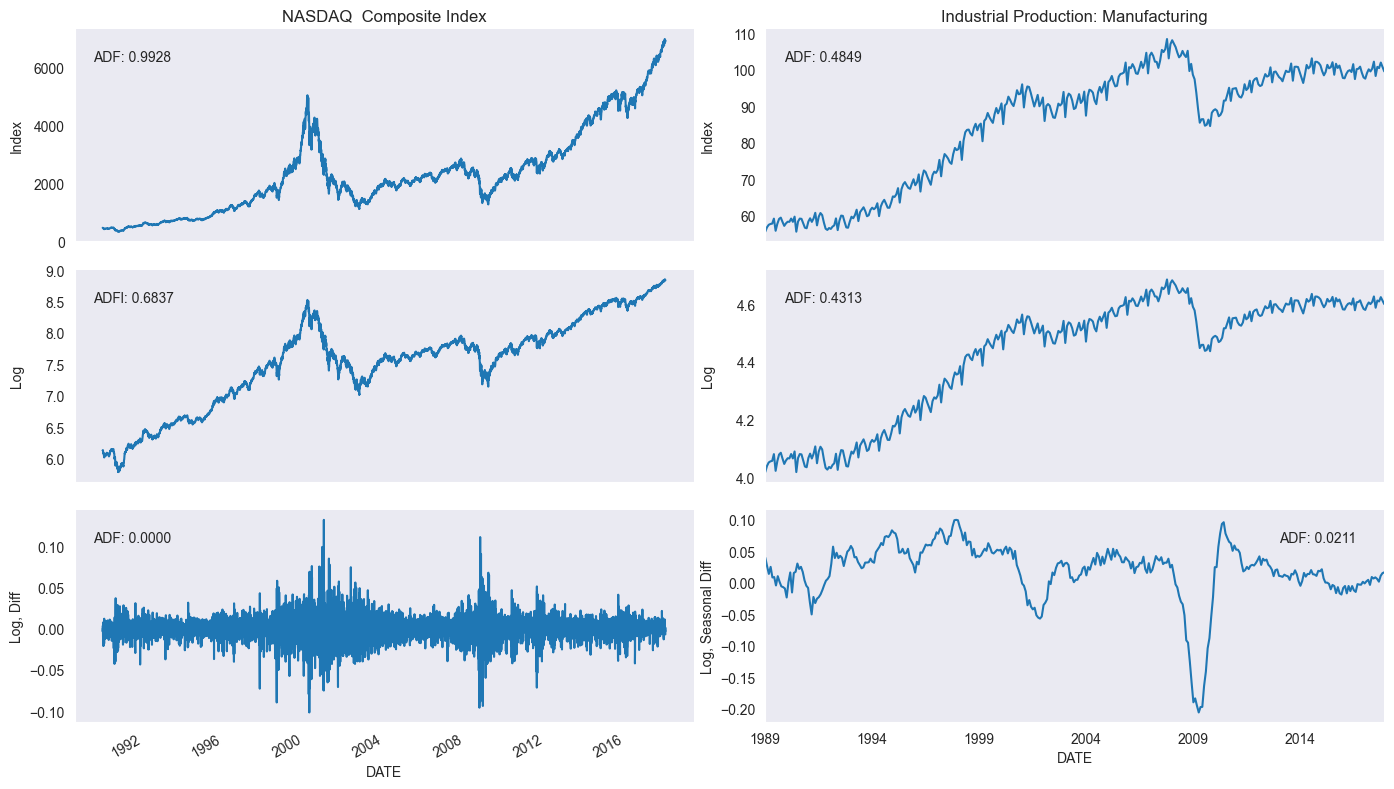

In [10]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))

    nasdaq.plot(ax=axes[0][0],
                title='NASDAQ  Composite Index')
    axes[0][0].text(x=.03,
                    y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq.dropna())[1]:.4f}',
                    transform=axes[0][0].transAxes)
    axes[0][0].set_ylabel('Index')

    nasdaq_log.plot(ax=axes[1][0],
                    sharex=True)
    axes[1][0].text(x=.03, y=.85,
                    s=f'ADFl: {tsa.adfuller(nasdaq_log.dropna())[1]:.4f}',
                    transform=axes[1][0].transAxes)
    axes[1][0].set_ylabel('Log')

    nasdaq_log_diff.plot(ax=axes[2][0],
                    sharex=True)
    axes[2][0].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][0].transAxes)
    axes[2][0].set_ylabel('Log, Diff')

    industrial_production.plot(ax=axes[0][1],
                               title='Industrial Production: Manufacturing')
    axes[0][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production)[1]:.4f}',
                    transform=axes[0][1].transAxes)
    axes[0][1].set_ylabel('Index')

    industrial_production_log.plot(ax=axes[1][1],
                    sharex=True)
    axes[1][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log.dropna())[1]:.4f}',
                    transform=axes[1][1].transAxes)
    axes[1][1].set_ylabel('Log')

    industrial_production_log_diff.plot(ax=axes[2][1],
                    sharex=True)
    axes[2][1].text(x=.83, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][1].transAxes)
    axes[2][1].set_ylabel('Log, Seasonal Diff')
    sns.despine()
    fig.tight_layout()
    fig.align_ylabels(axes)

- 나스닥 종합 지수: 나스닥 증권 거래소에 상장된 주식들의 시장 지수를 나타내며, 시간에 따라 전반적으로 상승 추세를 보이고 있습니다.
    - ACF (0.6313): 로그를 취한 값의 ACF는 완만해짐
- 산업 생산: 제조업: 제조업의 산업 생산을 나타내며, 점진적인 증가세와 일부 하락 기간이 보입니다.
    - 시계열 반영하여 diff 적용결과 편차가 더욱 커진 것 확인


## 코렐로그램(Correlogram)

자기 상관(시리얼 상관이라고도 함)은 상관 개념을 시계열 맥락에 적용한 것입니다. 상관 계수가 두 변수 간의 선형적 관계의 강도를 측정하는 것처럼, 자기 상관 계수 ρk는 주어진 지연 k로 분리된 시계열 값 간의 선형적 관계의 정도를 측정합니다.


따라서 시계열의 T-1 지연 각각에 대해 하나의 자기 상관 계수를 계산할 수 있습니다. T는 시계열의 길이입니다. 자기 상관 함수(ACF)는 지연의 함수로 상관 계수를 계산합니다. 1보다 큰 지연(즉, 1개 이상의 시간 간격으로 떨어진 관측치 간)에 대한 자기 상관은 이러한 관측치 간의 직접적인 상관과 개입하는 데이터 포인트의 간접적인 영향을 모두 반영합니다. 편자기 상관은 이러한 영향을 제거하고 주어진 지연 거리에서 데이터 포인트 간의 선형적 의존성만 측정합니다. 편자기 상관 함수(PACF)는 더 짧은 지연에서 상관의 영향이 제거된 후 발생하는 모든 상관을 제공합니다.


PACF와 ACF 간의 정확한 이론적 관계를 기반으로 샘플 자기 상관에서 편자기 상관을 추정하는 알고리즘이 있습니다.


코렐로그램은 단순히 순차적 지연 k=0,1,...,n에 대한 ACF 또는 PACF의 플롯입니다. 한눈에 여러 지연에 걸친 상관 구조를 검사할 수 있습니다. 코렐로그램의 주요 용도는 결정적 추세 또는 계절성의 영향을 제거한 후 자기 상관을 감지하는 것입니다. ACF와 PACF는 모두 선형 시계열 모델 설계를 위한 주요 진단 도구이며, 다음 시계열 변환 섹션에서 ACF와 PACF 플롯의 예를 검토합니다.

### NASDAQ (로그, 차분)

Q-Q 플롯을 사용하여 시계열 관측치 분포의 분위수를 정규 분포의 분위수와 비교하고 ACF와 PACF를 기반으로 한 코렐로그램을 사용하여 변환된 시계열의 관련 시계열 특성을 추가로 분석할 수 있습니다.


NASDAQ 플롯의 경우 추세는 없지만 분산은 일정하지 않고 오히려 1980년대 후반, 2001년, 2008년의 시장 혼란기에 군집된 스파이크를 보입니다. Q-Q 플롯은 정규 분포에서 제안하는 것보다 극단값이 더 빈번한 분포의 왜곡된 꼬리를 강조합니다. ACF와 PACF는 여러 지연에서 자기 상관이 유의미하게 나타나는 유사한 패턴을 보입니다.

In [14]:
def plot_correlogram(x, lags=None, title=None):
    """시계열 데이터의 자기 상관과 편자기 상관을 시각화하는 함수

    Args:
        x: 시계열 데이터
        lags: 자기 상관과 편자기 상관을 계산할 지연 수(기본값: 데이터 길이의 1/5 또는 최대 10)
        title: 그래프 제목(선택 사항)
    """

    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='residual')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-stats: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}' 
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nStd: {np.sqrt(var):>16.2f}\nSkewness: {skew:12.2f}\nkurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        axes[1][0].set_xlabel('지연')
        axes[1][1].set_xlabel('지연')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

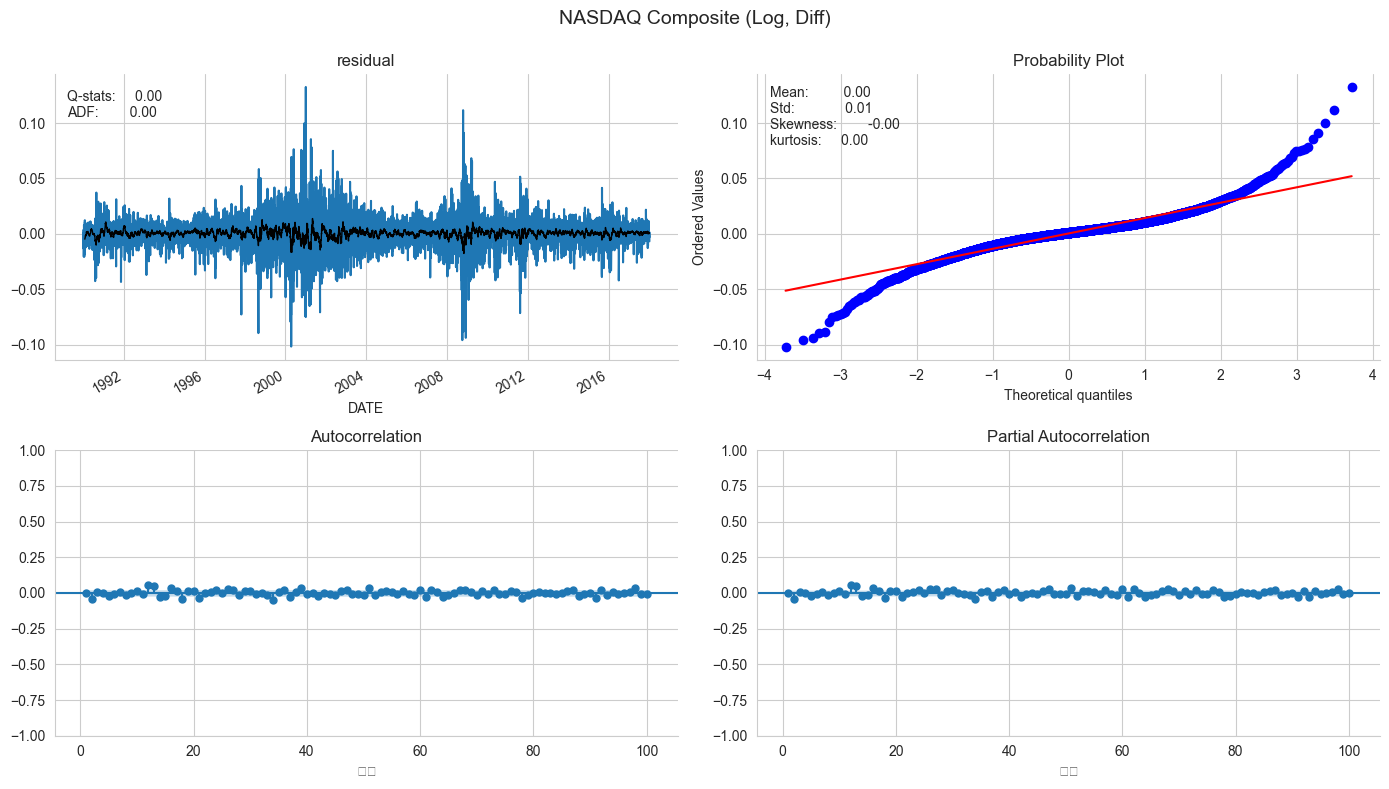

In [15]:
plot_correlogram(nasdaq_log_diff, lags=100, title='NASDAQ Composite (Log, Diff)')

### 산업 생산(로그, 계절적 차분)

산업 제조 생산에 대한 월간 시계열의 경우, 2008년 위기 이후 큰 음의 이상치와 Q-Q 플롯에서 해당 왜도가 나타납니다. 자기 상관은 NASDAQ 수익률보다 훨씬 높고 매끄럽게 감소합니다. PACF는 지연 1과 13에서 뚜렷한 양의 자기 상관 패턴과 지연 3과 4에서 유의미한 음의 계수를 보입니다.

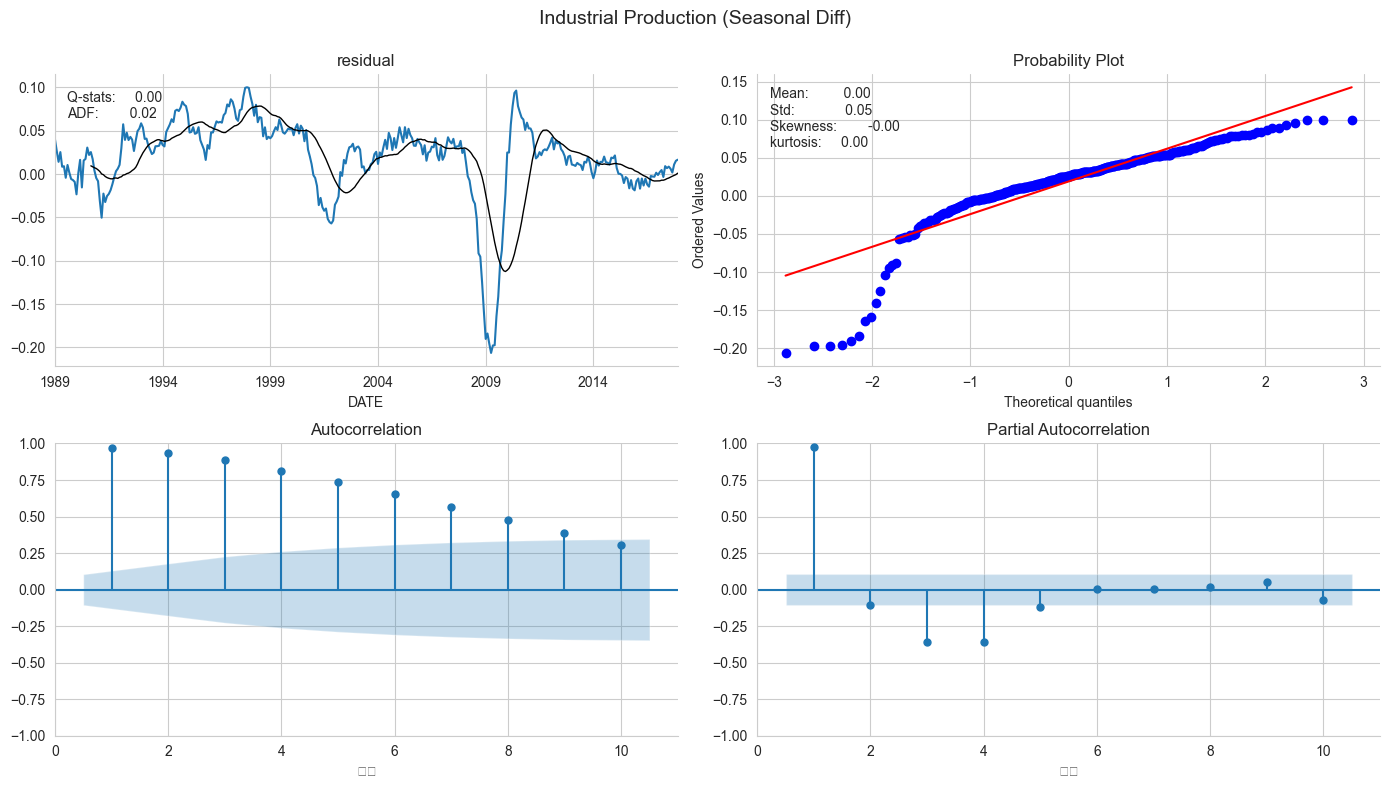

In [16]:
plot_correlogram(industrial_production_log_diff, title='Industrial Production (Seasonal Diff)')

# 단변량 ARIMA 모델

단변량 ARIMA 모델은 시계열 데이터를 모델링하는 데 사용되는 통계적 모델 유형입니다. ARIMA는 다음을 나타냅니다.



AR: 자기 회귀(AutoRegressive)
I: 적분(Integrated)
MA: 이동 평균(Moving Average)

ARIMA 모델은 다음과 같은 형태로 표현됩니다.


ARIMA(p, d, q)

여기서:



p: AR 차수(시계열의 과거 값이 현재 값에 영향을 미치는 지연 수)
d: 적분 차수(시계열을 정상적으로 만들기 위해 필요한 차분 수)
q: MA 차수(시계열의 과거 오류가 현재 오류에 영향을 미치는 지연 수)

단변량 ARIMA 모델은 시계열 데이터의 추세, 계절성, 잔차를 모델링하는 데 사용할 수 있습니다. ARIMA 모델은 시계열 데이터의 예측과 시계열 데이터를 기반으로 한 의사 결정에 사용할 수 있습니다.


단변량 ARIMA 모델을 구축하는 단계는 다음과 같습니다.



시계열 데이터를 분석하여 적절한 ARIMA 모델을 선택합니다.
ARIMA 모델을 시계열 데이터에 맞춥니다.
ARIMA 모델의 적합성을 평가합니다.
ARIMA 모델을 사용하여 시계열 데이터를 예측합니다.

단변량 ARIMA 모델은 시계열 데이터를 모델링하는 데 강력한 도구입니다. 시계열 데이터의 예측과 시계열 데이터를 기반으로 한 의사 결정에 사용할 수 있습니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [65]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

In [4]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

Load monthly industrial production and daily NASDAQ stock market index:

In [5]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

In [6]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

In [38]:
nasdaq_log_diff = nasdaq_log.diff(1).dropna()

# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

## 단변량 시계열 모델 (Univariate Time Series Models)

### 자기회귀 모델 (AR Model)

- 시계열의 값: 관심 시점에서 지연된 값과 과거 교란항을 선형조합하여 시계열 값을 예측
    - 지연된 값: 과거 시계열 값
    - 과거 교란 항: 과거 잔차
    - 선형 조합: 지연된 값과 과거 교란 항을 가중치로 곱한 다음 더하여 현재 값을 예측합니다.
    
지수 평활 모델이 데이터의 추세와 계절성에 대한 설명을 기반으로 하는 반면, ARIMA 모델은 데이터의 자기 상관을 설명하는 것을 목표로 합니다. ARIMA(p, d, q) 모델은 정상성을 필요로 하고 다음 두 가지 구성 요소를 활용합니다.

- 시계열의 p-지연된 값으로 구성된 자기 회귀(AR) 항
- q-지연된 교란을 포함하는 이동 평균(MA) 항 <br>

8장에서는 ARIMA 구성 요소, 단순 자기 회귀(AR) 및 이동 평균(MA) 모델을 소개하고, 이를 자기 회귀 이동 평균(ARMA) 모델에 결합하여 ARIMA 모델로 시계열 적분을 설명하거나 AR(I)MAX 모델로 외생 변수를 포함하는 방법을 설명합니다.


또한 계절적 AR 및 MA 항을 포함하여 툴박스를 확장하여 SARMAX 모델도 포함하는 방법을 설명합니다.

### ARMA vs ARIMA

차분된 시계열의 ARMA 모델은 차분되지 않은 시계열의 ARIMA 모델과 동일한 결과를 생성합니다.

In [39]:
from statsmodels.tsa.arima.model import ARIMA

model1 = ARIMA(endog=nasdaq_log_diff, order=(2,0,2)).fit()
model2 = ARIMA(endog=nasdaq_log, order=(2,1,2)).fit()

In [40]:
model1.params.to_frame('ARMA').join(model2.params.to_frame('diff'))

,ARMA,diff
const,0.000383,NaN
ar.L1,-0.188582,-0.224551
ar.L2,-0.130675,-0.169854
ma.L1,0.187295,0.224049
ma.L2,0.088260,0.128358
sigma2,0.000208,0.000208


### 계절적 차분과 SARIMAX

계절적 차분은 계절적 순서(0,1,0,12)를 사용하는 SARIMAX와 동일한 효과가 있습니다.

In [41]:
model1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
model2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()

In [42]:
model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))

,SARIMAX,diff
ar.L1,1.768300,1.768300
ar.L2,-0.790607,-0.790607
ma.L1,-0.844845,-0.844845
ma.L2,0.311257,0.311257
sigma2,0.000102,0.000102


## Finding the optimal ARMA lags

### Run candidate models

We iterate over various (p, q) lag combinations and collect diagnostic statistics to compare the result.

In [47]:
from sklearn.metrics import mean_squared_error
train_size = 120
results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARIMA(endog=train_set, order=(p,0,q)).fit()
            except:
                convergence_error += 1
                continue
            forecast = model.forecast()[0]
            y_pred.append(forecast)
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [48]:
arma_results = pd.DataFrame(results).T
arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          24 non-null     float64
 1   AIC           24 non-null     float64
 2   BIC           24 non-null     float64
 3   convergence   24 non-null     float64
 4   stationarity  24 non-null     float64
dtypes: float64(5)
memory usage: 1.5 KB


In [49]:
with pd.HDFStore('arima.h5') as store:
    store.put('arma', arma_results)

We aim to minimize both RMSE and BIC:

In [50]:
arma_results.nsmallest(5, columns=['RMSE'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
4 0  0.009943 -756.279035 -739.554085          0.0           0.0
  1  0.010133 -755.041527 -735.529085          0.0           0.0
2 3  0.010207 -755.702236 -736.189793          0.0           0.0
  2  0.010259 -755.512366 -738.787415          0.0           0.0
  4  0.010328 -753.541890 -731.241956          0.0           0.0

In [51]:
arma_results.nsmallest(5, columns=['BIC'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
4 0  0.009943 -756.279035 -739.554085          0.0           0.0
2 2  0.010259 -755.512366 -738.787415          0.0           0.0
  3  0.010207 -755.702236 -736.189793          0.0           0.0
4 1  0.010133 -755.041527 -735.529085          0.0           0.0
3 2  0.010572 -754.200184 -734.687742          0.0           0.0

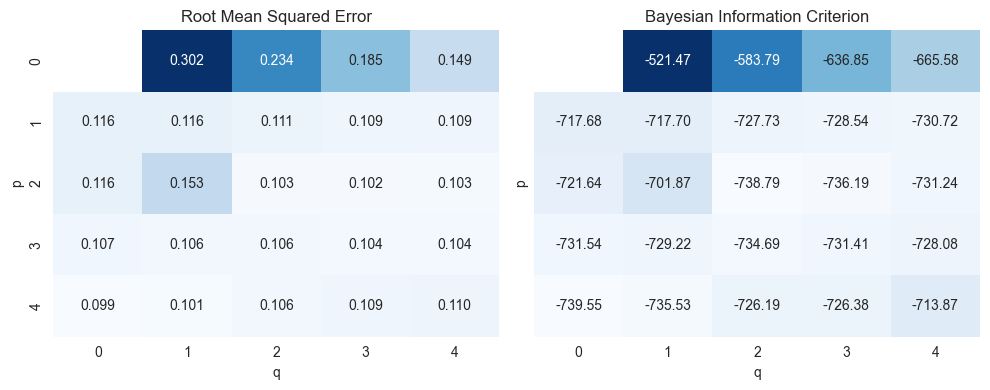

In [52]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
sns.heatmap(arma_results[arma_results.RMSE<.5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(arma_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
fig.tight_layout();

In [53]:
arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

p  q
4  0    1.0
2  2    3.0
   3    3.0
4  1    3.0
2  4    6.5
dtype: float64

### Estimating the best ARMA Model

ARMA(4,0) and ARMA(4,1) are close, so we chose the more parsimonious (4,0) configuration:

In [54]:
best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()

In [56]:
best_arma_model = tsa.ARIMA(endog=industrial_production_log_diff, order=(best_p, 0, best_q)).fit()
print(best_arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 IPGMFN   No. Observations:                  348
Model:                 ARIMA(4, 0, 0)   Log Likelihood                1104.301
Date:                Thu, 16 May 2024   AIC                          -2196.603
Time:                        05:42:47   BIC                          -2173.489
Sample:                    01-01-1989   HQIC                         -2187.401
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.010      1.879      0.060      -0.001       0.039
ar.L1          0.9329      0.044     21.023      0.000       0.846       1.020
ar.L2          0.3346      0.076      4.388      0.0

### Check Residual Correlogram

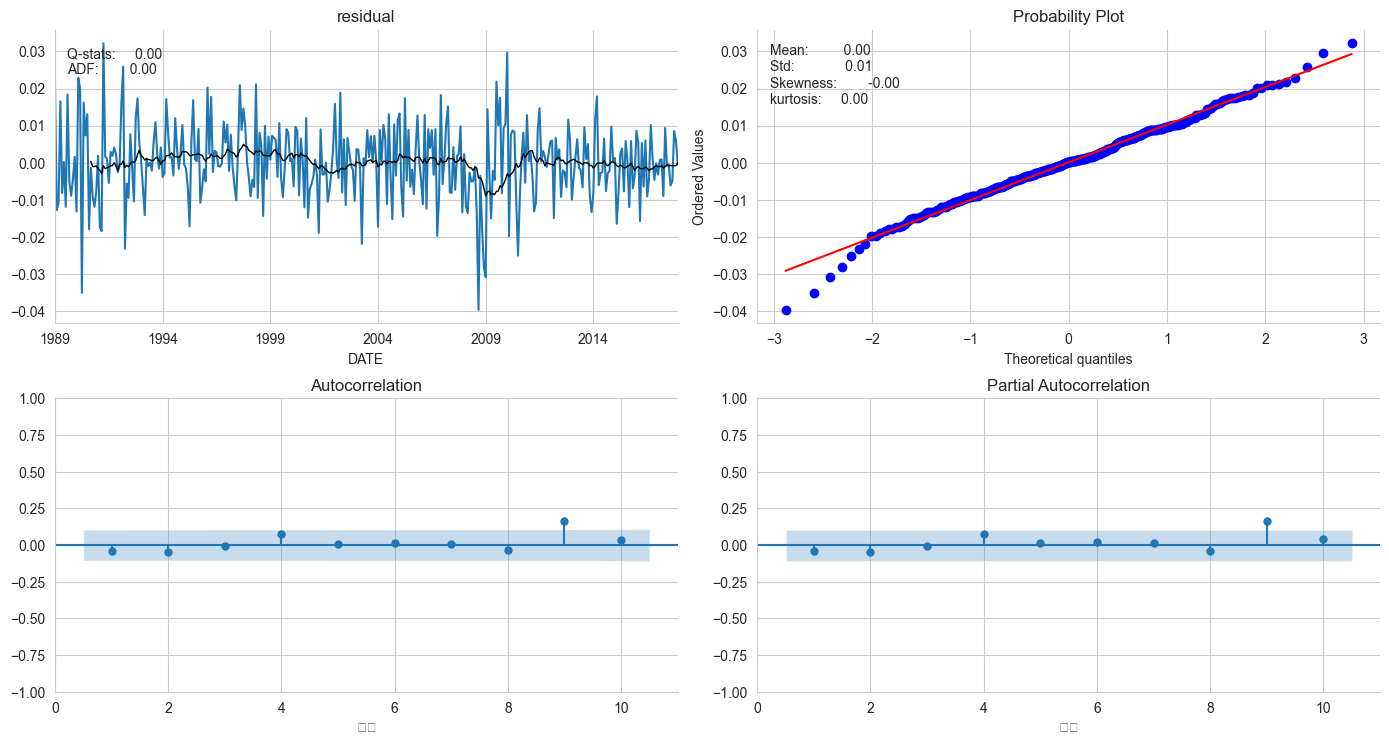

In [57]:
plot_correlogram(best_arma_model.resid)

## SARIMAX

In [58]:
sarimax_model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna().values,
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])

In [59]:
print(sarimax_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                1126.632
Date:                              Thu, 16 May 2024   AIC                          -2239.264
Time:                                      05:43:04   BIC                          -2212.299
Sample:                                           0   HQIC                         -2228.529
                                              - 348                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0126      0.437      0.029      0.977      -0.843       0.869
ar.L2          0.98

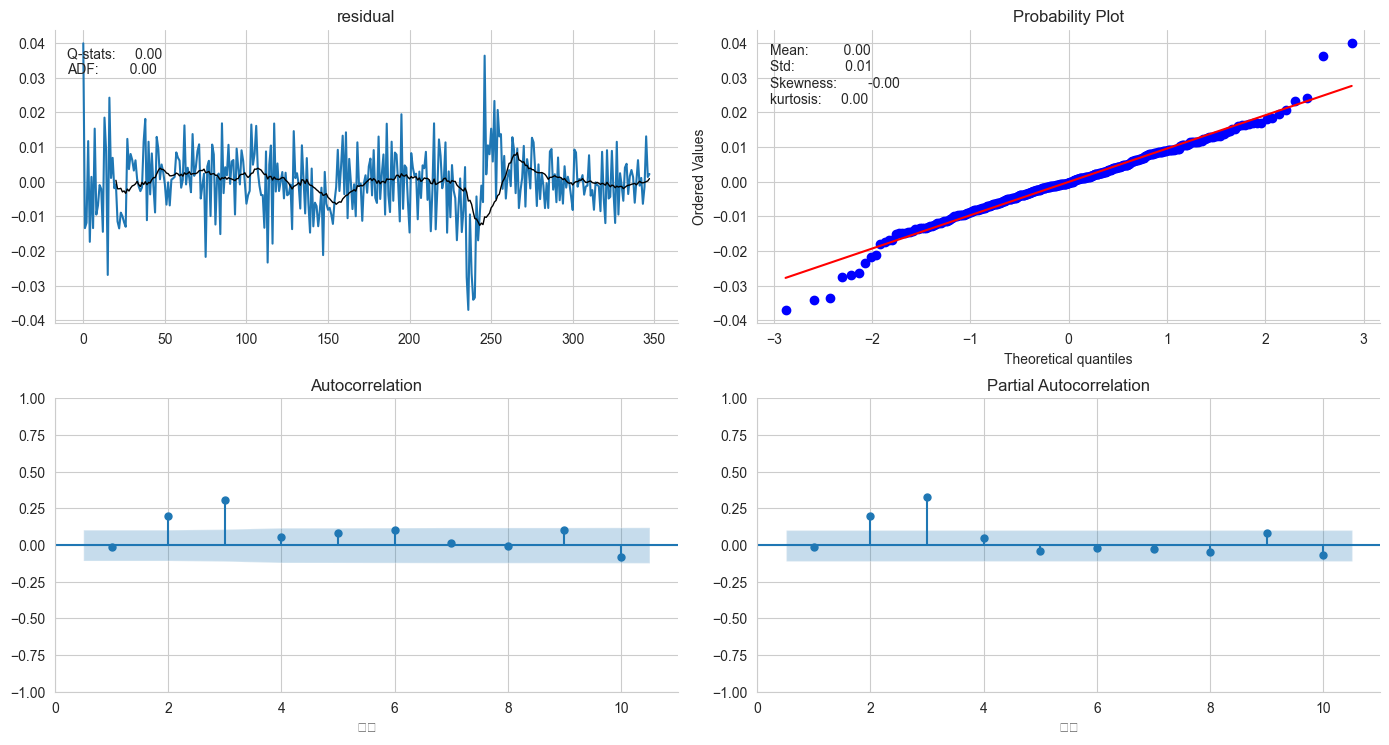

In [60]:
plot_correlogram(pd.Series(sarimax_model.resid))

We will build a SARIMAX model for monthly data on an industrial production time series for the 1988-2017 period. As illustrated in the first section on analytical tools, the data has been log-transformed, and we are using seasonal (lag-12) differences. We estimate the model for a range of both ordinary and conventional AR and MA parameters using a rolling window of 10 years of training data, and evaluate the RMSE of the 1-step-ahead forecast.

### Finding the optimal number of lags

This takes a while...

In [66]:
l3 = list(range(3))
l4 = list(range(4))
params = [t for t in product(l4, l4, l3, l3) if t[0] > 0 and t[1] >  0]
len(params)

81

In [67]:
train_size = 120 # 10 years of training data
results = {}
test_set = industrial_production_log_diff.iloc[train_size:]

for p1, q1, p2, q2 in tqdm(params):
    preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
    aic, bic = [], []
    if p1 == 0 and q1 == 0:
        continue
    convergence_error = stationarity_error = 0
    y_pred = []
    for i, T in enumerate(range(train_size, len(industrial_production_log_diff))):
        train_set = industrial_production_log_diff.iloc[T-train_size:T]
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = tsa.SARIMAX(endog=train_set.values,
                                order=(p1, 0, q1),
                                seasonal_order=(p2, 0, q2, 12)).fit(disp=0)
        except LinAlgError:
            convergence_error += 1
        except ValueError:
            stationarity_error += 1

        preds.iloc[i, 1] = model.forecast(steps=1)[0]
        aic.append(model.aic)
        bic.append(model.bic)

    preds.dropna(inplace=True)
    mse = mean_squared_error(preds.y_true, preds.y_pred)
    results[(p1, q1, p2, q2)] = [np.sqrt(mse),
                                      preds.y_true.sub(preds.y_pred).pow(2).std(),
                                      np.mean(aic),
                                      np.std(aic),                                                  
                                      np.mean(bic),
                                      np.std(bic),                                                  
                                      convergence_error,
                                      stationarity_error]

100%|███████████████████████████████████████████████████████████████████████████████| 81/81 [2:35:22<00:00, 115.09s/it]


### Compare model metrics

In [68]:
sarimax_results = pd.DataFrame(results).T
sarimax_results.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
sarimax_results['CV'] = sarimax_results.RMSE_std.div(sarimax_results.RMSE)
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 81 entries, (1, 1, 0, 0) to (3, 3, 2, 2)
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          81 non-null     float64
 1   RMSE_std      81 non-null     float64
 2   AIC           81 non-null     float64
 3   AIC_std       81 non-null     float64
 4   BIC           81 non-null     float64
 5   BIC_std       81 non-null     float64
 6   convergence   81 non-null     float64
 7   stationarity  81 non-null     float64
 8   CV            81 non-null     float64
dtypes: float64(9)
memory usage: 6.7 KB


In [69]:
with pd.HDFStore('arima.h5') as store:
    store.put('sarimax', sarimax_results)

In [70]:
with pd.HDFStore('arima.h5') as store:
    sarimax_results = store.get('sarimax')

In [71]:
sarimax_results.nsmallest(5, columns='RMSE')

RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
3  2  1  1   0.008901  0.000156 -772.628666  20.837396 -750.328733  20.837396   
      0  2   0.008977  0.000164 -771.734664  23.793885 -749.434730  23.793885   
   3  0  2   0.009007  0.000159 -772.159281  28.276165 -747.071855  28.276165   
      1  2   0.009085  0.000159 -773.842453  26.610987 -745.967536  26.610987   
      2  1   0.009096  0.000148 -769.839168  21.649144 -741.964251  21.649144   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
3  2  1  1           0.0           0.0  0.017509  
      0  2           0.0           0.0  0.018316  
   3  0  2           0.0           0.0  0.017621  
      1  2           0.0           0.0  0.017525  
      2  1           0.0           0.0  0.016286

We also collect the AIC and BIC criteria that show a very high rank correlation coefficient of 0.94, with BIC favoring models with slightly fewer parameters than AIC. The best five models by RMSE are:

In [72]:
sarimax_results[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head()

RMSE         AIC         BIC
p1 q1 p2 q2                                  
3  2  1  1   0.008901 -772.628666 -750.328733
      0  2   0.008977 -771.734664 -749.434730
   3  0  2   0.009007 -772.159281 -747.071855
      1  2   0.009085 -773.842453 -745.967536
      2  1   0.009096 -769.839168 -741.964251

In [73]:
sarimax_results[['RMSE', 'AIC', 'BIC']].corr('spearman')

,RMSE,AIC,BIC
RMSE,1.000000,0.916734,0.779810
AIC,0.916734,1.000000,0.860276
BIC,0.779810,0.860276,1.000000


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

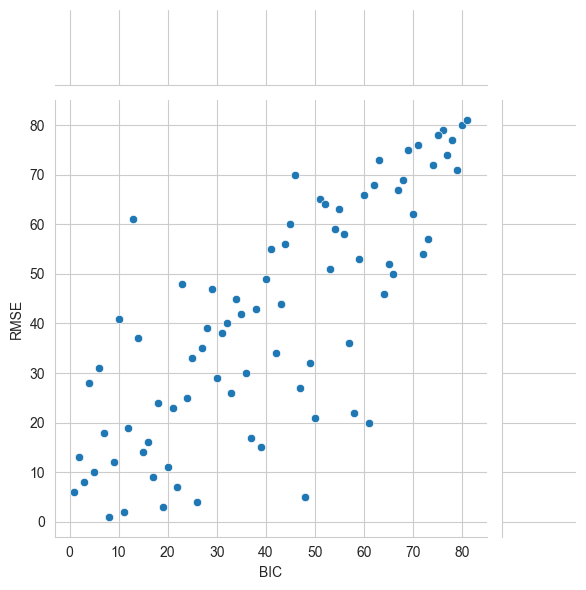

In [74]:
sns.jointplot(y='RMSE', x='BIC', data=sarimax_results[['RMSE', 'BIC']].rank());

In [ ]:
sarimax_results[(sarimax_results.RMSE < sarimax_results.RMSE.quantile(.05)) &
                (sarimax_results.BIC < sarimax_results.BIC.quantile(.1))].sort_values('RMSE')

### Train best model

In [ ]:
p1, q1, p2, q2 = 2, 3, 1, 2

In [ ]:
best_model = tsa.SARIMAX(endog=industrial_production_log_diff.values, order=(p1, 0, q1),
                         seasonal_order=(p2, 0, q2, 12)).fit()

In [ ]:
print(best_model.summary())

### Check Residual Correlogram

In [ ]:
plot_correlogram(pd.Series(best_model.resid),
                 lags=20,
                 title=f'SARIMAX ({p1}, 0, {q1}) x ({p2}, 0, {q2}, 12) | Model Diagnostics')

# ARCH/GARCH 변동성 예측

자산 수익률 시계열에 대한 변동성 모델을 개발하는 것은 다음과 같은 4단계로 구성됩니다.


ACF와 PACF에서 드러난 시계열 의존성을 기반으로 금융 시계열에 대한 ARMA 시계열 모델을 구축합니다.
제곱 잔차 시계열에 대한 ACF와 PACF에 다시 의존하여 모델의 잔차에 대한 ARCH/GARCH 효과를 테스트합니다.
시계열 상관 효과가 유의미한 경우 변동성 모델을 지정하고 평균 및 변동성 방정식을 공동으로 추정합니다.
적합된 모델을 신중하게 확인하고 필요한 경우 개선합니다.
변동성 예측을 수익률 시계열에 적용할 때 시계열 의존성이 제한될 수 있으므로 ARMA 모델 대신 상수 평균을 사용할 수 있습니다.

arch 라이브러리는 변동성 예측 모델을 추정하는 데 여러 옵션을 제공합니다. 상수 평균, 위의 단변량 시계열 모델 섹션에서 논의한 AR(p) 모델, 단기, 중기, 장기 투자자의 거래 빈도를 포착하기 위해 일일(1일), 주간(5일), 월간(22일) 지연을 사용하는 최근의 이기종 자기 회귀 과정(HAR)을 포함하여 예상 평균을 모델링하는 여러 옵션을 제공합니다.


평균 모델은 ARCH와 GARCH 외에도 양수와 음수 수익률 간의 비대칭 효과를 허용하는 지수 GARCH(EGARCH) 모델과 HAR 평균 모델을 보완하는 이기종 ARCH(HARCH) 모델을 포함하는 여러 조건부 이분산성 모델과 공동으로 정의하고 추정할 수 있습니다.

## Imports & Settings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller

from sklearn.metrics import mean_squared_error

from scipy.stats import probplot, moment

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_style('whitegrid')

## Correlogram Plot

In [ ]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Download NASDAQ Index Data

We will use daily NASDAQ returns from 1998-2017 to demonstrate the usage of a GARCH model

In [ ]:
nasdaq = web.DataReader('NASDAQCOM', 'fred', '2000', '2020').squeeze()
nasdaq_returns = np.log(nasdaq).diff().dropna().mul(100) # rescale to faciliate optimization

## Explore Returns and Volatility

The rescaled daily return series exhibits only limited autocorrelation, but the squared deviations from the mean do have substantial memory reflected in the slowly-decaying ACF and the PACF high for the first two and cutting off only after the first six lags:

In [ ]:
plot_correlogram(nasdaq_returns, lags=250, title='NASDAQ Daily Returns')

The function plot_correlogram produces the following output:

In [ ]:
plot_correlogram(nasdaq_returns.sub(nasdaq_returns.mean()).pow(2), lags=120, title='NASDAQ Daily Volatility')

## Model Selection: rolling out-of-sample forecasts

Hence, we can estimate a GARCH model to capture the linear relationship of past volatilities. We will use rolling 10-year windows to estimate a GARCH(p, q) model with p and q ranging from 1-4 to generate 1-step out-of-sample forecasts. 

We then compare the RMSE of the predicted volatility relative to the actual squared deviation of the return from its mean to identify the most predictive model. We are using winsorized data to limit the impact of extreme return values reflected in the very high positive skew of the volatility

In [ ]:
trainsize = 10 * 252  # 10 years
data = nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05),
                           upper=nasdaq_returns.quantile(.95))
T = len(nasdaq_returns)
results = {}
for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t+1]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

In [ ]:
s = pd.Series(results)
s.index.names = ['p', 'q']
s = s.unstack().sort_index(ascending=False)

In [ ]:
sns.heatmap(s, cmap='Blues', annot=True, fmt='.4f')
plt.title('Out-of-Sample RMSE');

## Estimate GARCH(2, 2) Model

The GARCH(2, 2) model achieves the second-lowest RMSE but has fewer parameters than the slightly better-performing GARCH(2, 4), so we go ahead and estimate this model to inspect the summary.

The output shows the maximized log-likelihood as well as the AIC and BIC criteria that are commonly minimized when selecting models based on in-sample performance (see Chapter 7, Linear Models). It also displays the result for the mean model, which in this case is just a constant estimate, as well as the GARCH parameters for the constant omega, the AR parameters, α, and the MA parameters, β, all of which are statistically significant:

In [ ]:
best_p, best_q = 2, 2,

In [ ]:
am = ConstantMean(nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05),
                                      upper=nasdaq_returns.quantile(.95)))
am.volatility = GARCH(best_p, 0, best_q)
am.distribution = Normal()
best_model = am.fit(update_freq=5)
print(best_model.summary())

### Check Residuals

In [ ]:
fig = best_model.plot(annualize='D')
fig.set_size_inches(12, 8)
fig.tight_layout();

In [ ]:
plot_correlogram(best_model.resid.dropna(),
                 lags=250,
                 title='GARCH Residuals')

# How to use the VAR model for macro fundamentals forecasts

The vector autoregressive VAR(p) model extends the AR(p) model to k series by creating a system of k equations where each contains p lagged values of all k series. The coefficients on the own lags provide information about the dynamics of the series itself, whereas the cross-variable coefficients offer some insight into the interactions across the series.

## Imports and Settings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error

In [ ]:
sns.set(style='whitegrid',
        context='notebook',
        color_codes=True)

## Helper Functions

### Correlogram Plot

In [ ]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Time Series')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### Unit Root Test

In [ ]:
def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')

## Load Data

We will extend the univariate example of a single time series of monthly data on industrial production and add a monthly time series on consumer sentiment, both provided by the Federal Reserve's data service. We will use the familiar pandas-datareader library to retrieve data from 1970 through 2017:

In [ ]:
sent = 'UMCSENT'
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1970', '2019-12').dropna()
df.columns = ['sentiment', 'ip']

In [ ]:
df.info()

In [ ]:
df.plot(subplots=True, figsize=(14,8), rot=0)
sns.despine()
plt.tight_layout();

In [ ]:
plot_correlogram(df.sentiment, lags=24)

In [ ]:
plot_correlogram(df.ip, lags=24)

## Stationarity Transform

Log-transforming the industrial production series and seasonal differencing using lag 12 of both series yields stationary results:

In [ ]:
df_transformed = pd.DataFrame({'ip': np.log(df.ip).diff(12),
                              'sentiment': df.sentiment.diff(12)}).dropna()

## Inspect Correlograms

In [ ]:
plot_correlogram(df_transformed.sentiment, lags=24)

In [ ]:
plot_correlogram(df_transformed.ip, lags=24)

In [ ]:
test_unit_root(df_transformed)

In [ ]:
df_transformed.plot(subplots=True, figsize=(14, 8),
                    title=['Industrial Production', 'Consumer Sentiment'],
                    legend=False,
                    rot=0)
sns.despine()
plt.tight_layout()

## VAR Model

To limit the size of the output, we will just estimate a VAR(1) model using the statsmodels VARMAX implementation (which allows for optional exogenous variables) with a constant trend through 2017. The output contains the coefficients for both time series equations.

In [ ]:
df_transformed = df_transformed.apply(minmax_scale)

In [ ]:
model = VARMAX(df_transformed.loc[:'2017'], order=(1,1), trend='c').fit(maxiter=1000)

In [ ]:
print(model.summary())

### Plot Diagnostics

`statsmodels` provides diagnostic plots to check whether the residuals meet the white noise assumptions, which are not exactly met in this simple case:

#### Industrial Production

In [ ]:
model.plot_diagnostics(variable=0, figsize=(14,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

#### Sentiment

In [ ]:
model.plot_diagnostics(variable=1, figsize=(14,8), lags=24)
plt.title('Sentiment - Diagnostics');

### Impulse-Response Function

In [ ]:
median_change = df_transformed.diff().quantile(.5).tolist()
model.impulse_responses(steps=12,
                        impulse=median_change).plot.bar(subplots=True,
                                                        figsize=(12, 6),
                                                        rot=0,
                                                        legend=False)
sns.despine()
plt.tight_layout()

### Generate Predictions

Out-of-sample predictions can be generated as follows:

In [ ]:
n =len(df_transformed)
start = n-24

preds = model.predict(start=start+1, end=n)

In [ ]:
preds.index = df_transformed.index[start:]

fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed.ip.loc['2010':].plot(ax=axes[0], label='actual', title='Industrial Production')
preds.ip.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.sentiment.loc['2010':].plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

### Out-of-sample forecasts

A visualization of actual and predicted values shows how the prediction lags the actual values and does not capture non-linear out-of-sample patterns well:

In [ ]:
forecast = model.forecast(steps=24)

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed['2010':].ip.plot(ax=axes[0], label='actual', title='Liquor')
preds.ip.plot(label='predicted', ax=axes[0])
axes[0].legend()

df_transformed['2010':].sentiment.plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].legend()
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

In [ ]:
mean_absolute_error(forecast, df_transformed.iloc[492:])

# Cointegration Tests & Pairs Trading

## What is cointegration?
We have seen how a time series can have a unit root that creates a stochastic trend and makes the time series highly persistent. When we use such an integrated time series in their original, rather than in differenced, form as a feature in a linear regression model, its relationship with the outcome will often appear statistically significant, even though it is not. This phenomenon is called spurious regression (for details, see Chapter 18 in [Wooldridge, 2008](https://economics.ut.ac.ir/documents/3030266/14100645/Jeffrey_M._Wooldridge_Introductory_Econometrics_A_Modern_Approach__2012.pdf)). Therefore, the recommended solution is to difference the time series so they become stationary before using them in a model.

However, there is an exception when there are cointegration relationships between the outcome and one or more input variables. To understand the concept of cointegration, let's first remember that the residuals of a regression model are a linear combination of the inputs and the output series.

Usually, the residuals of the regression of one integrated time series on one or more such series yields non-stationary residuals that are also integrated, and thus behave like a random walk. However, for some time series, this is not the case: the regression produces coefficients that yield a linear combination of the time series in the form of the residuals that are stationary, even though the individual series are not. Such time series are
cointegrated.

A non-technical example is that of a drunken man on a random walk accompanied by his dog (on a leash). Both trajectories are non-stationary but cointegrated because the dog will occasionally revert to his owner. In the trading context, arbitrage constraints imply cointegration between spot and futures prices.

In other words, a linear combination of two or more cointegrated series has a stable mean to which this linear combination reverts. This also applies when the individual series are integrated of a higher order and the linear combination reduces the overall order of integration.

Cointegration differs from correlation: two series can be highly correlated but need not be cointegrated. For example, if two growing series are constant multiples of each other, their correlation will be high, but any linear combination will also grow rather than revert to a stable mean.

## Cointegration for Pairs Trading

Cointegration is very useful: if two or more asset price series tend to revert to a common mean, we can leverage deviations from the trend because they should imply future price moves in the opposite direction. The mathematics behind cointegration is more involved, so we will only focus on the practical aspects; for an in-depth treatment, see [Lütkepohl (2005)](https://www.springer.com/gp/book/9783540401728).

In this notebook, we will address how we can identify pairs with such a long-term stationary relationship, estimate the expected time for any disequilibrium to correct, and how to utilize these tools to implement and backtest a long-short pairs trading strategy. There are two approaches to testing for cointegration:
- The Engle-Granger two-step method
- The Johansen test

The book chapter discusses each test in turn; in this notebook we show how they help identify cointegrated securities that tend to revert to a common trend, a fact that we can leverage for a statistical arbitrage
strategy.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
from time import time
from pathlib import Path
from tqdm import tqdm 

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [4]:
DATA_PATH = Path('..', 'data')
STORE = DATA_PATH / 'assets.h5'

### Johansen Test Critical Values

In [5]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [6]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

## Load & Clean Stock & ETF Data

### Remove highly correlated assets

In [7]:
def remove_correlated_assets(df, cutoff=.99):
    corr = df.corr().stack()
    corr = corr[corr < 1]
    to_check = corr[corr.abs() > cutoff].index
    keep, drop = set(), set()
    for s1, s2 in to_check:
        if s1 not in keep:
            if s2 not in keep:
                keep.add(s1)
                drop.add(s2)
            else:
                drop.add(s1)
        else:
            keep.discard(s2)
            drop.add(s2)
    return df.drop(drop, axis=1)

### Remove stationary series

In [8]:
def check_stationarity(df):
    results = []
    for ticker, prices in df.items():
        results.append([ticker, adfuller(prices, regression='ct')[1]])
    return pd.DataFrame(results, columns=['ticker', 'adf']).sort_values('adf')

In [9]:
def remove_stationary_assets(df, pval=.05):
    test_result = check_stationarity(df)
    stationary = test_result.loc[test_result.adf <= pval, 'ticker'].tolist()
    return df.drop(stationary, axis=1).sort_index()

### Select Assets

In [21]:
def select_assets(asset_class='stocks', n=500, start=2010, end=2019):
    idx = pd.IndexSlice
    with pd.HDFStore(STORE) as store:
        df = (pd.concat([store[f'stooq/us/nasdaq/{asset_class}/prices'],
                         store[f'stooq/us/nyse/{asset_class}/prices']])
              # stooq download can have duplicate assets
              .loc[lambda df: ~df.index.duplicated()]
              .sort_index()
              .loc[idx[:, f'{start}':f'{end}'], :]
              .assign(dv=lambda df: df.close.mul(df.volume)))

    # select n assets with the highest average trading volume
    # we are taking a shortcut to simplify; should select
    # based on historical only, e.g. yearly rolling avg
    most_traded = (df.groupby(level='ticker')
                   .dv.mean()
                   .nlargest(n=n).index)

    df = (df.loc[idx[most_traded, :], 'close']
          .unstack('ticker')
          .ffill(limit=5)  # fill up to five values
          .dropna(axis=1))  # remove assets with any missing values

    df = remove_correlated_assets(df)
    return remove_stationary_assets(df).sort_index()

We store the intermediate result:

In [22]:
for asset_class, n in [('etfs', 500), ('stocks', 250)]:
    df = select_assets(asset_class=asset_class, n=n)
    df.to_hdf('data.h5', f'{asset_class}/close')

### Get ticker dictionary

In [23]:
def get_ticker_dict():
    with pd.HDFStore(STORE) as store:
        return (pd.concat([
            store['stooq/us/nyse/stocks/tickers'],
            store['stooq/us/nyse/etfs/tickers'],
            store['stooq/us/nasdaq/etfs/tickers'],
            store['stooq/us/nasdaq/stocks/tickers']
        ]).drop_duplicates().set_index('ticker').squeeze().to_dict())

In [24]:
names = get_ticker_dict()

## Visualize Correlation Clusters 

Reload intermediate results:

In [25]:
stocks = pd.read_hdf('data.h5', 'stocks/close')
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 171 entries, AAPL.US to CLF.US
dtypes: float64(171)
memory usage: 3.3 MB


In [26]:
etfs = pd.read_hdf('data.h5', 'etfs/close')
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 139 entries, SPY.US to DBB.US
dtypes: float64(139)
memory usage: 2.7 MB


In [27]:
tickers = {k: v for k, v in names.items() if k in etfs.columns.union(stocks.columns)}
pd.Series(tickers).to_hdf('data.h5', 'tickers')

In [28]:
corr = pd.DataFrame(index=stocks.columns)
for etf, data in etfs.items():
    corr[etf] = stocks.corrwith(data)

In [29]:
corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171 entries, AAPL.US to CLF.US
Columns: 139 entries, SPY.US to DBB.US
dtypes: float64(139)
memory usage: 191.1+ KB


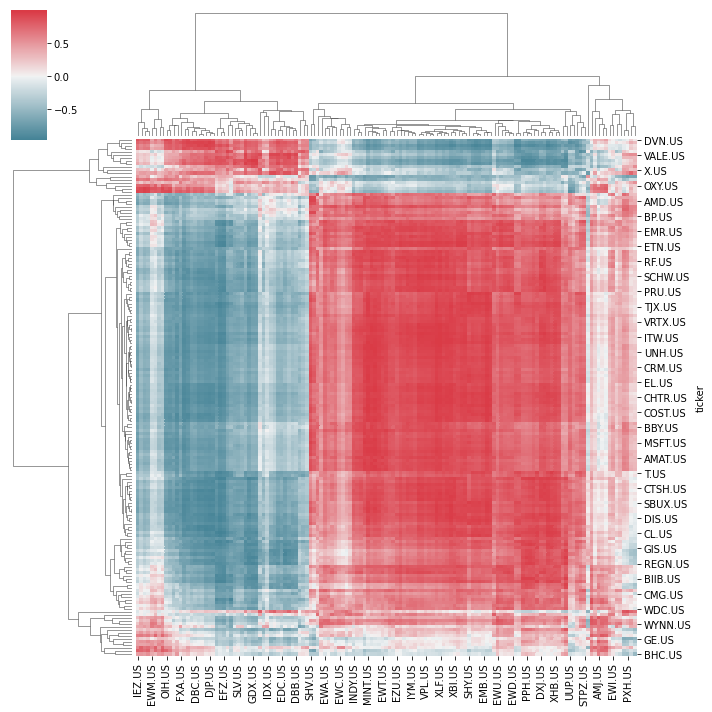

In [30]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.clustermap(corr, cmap=cmap, center=0);

## Candidate Selection using Heuristics

### Computational Complexity: Comparing running times

In this section, we compare the running times of various cointegration tests. More specifically, we are running tests for a single asset vs. the remaining set of securities.

#### Prepare Data

In [32]:
stocks.shape, etfs.shape

((2516, 171), (2516, 139))

In [33]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 171 entries, AAPL.US to CLF.US
dtypes: float64(171)
memory usage: 3.3 MB


In [34]:
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 139 entries, SPY.US to DBB.US
dtypes: float64(139)
memory usage: 2.7 MB


In [35]:
security = etfs['AAXJ.US'].loc['2010': '2013']
candidates = stocks.loc['2010': '2013']

In [36]:
security = security.div(security.iloc[0])
candidates = candidates.div(candidates.iloc[0])
spreads = candidates.sub(security, axis=0)

In [37]:
n, m = spreads.shape
X = np.ones(shape=(n, 2))
X[:, 1] = np.arange(1, n+1)

#### Heuristics

In [38]:
%%timeit
np.linalg.inv(X.T @ X) @ X.T @ spreads

710 µs ± 5.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [39]:
%%timeit
spreads.std()

1.01 ms ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [40]:
%%timeit
candidates.corrwith(security)

31 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Cointegration Tests

In [41]:
%%timeit
for candidate, prices in candidates.items():
    df = pd.DataFrame({'s1': security,
                       's2': prices})
    var = VAR(df.values)
    lags = var.select_order()
    k_ar_diff = lags.selected_orders['aic']
    coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
    coint(security, prices, trend='c')[:2]
    coint(prices, security, trend='c')[:2]

33.6 s ± 6.43 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Clearly, cointegration tests are significantly more costly. It would be great if the heuristics worked just as well, or at least 'good enough'.

### Compute Heuristics

The function `compute_pair_metrics()` computes the following distance metrics for over 23,000 pairs of
stocks and Exchange Traded Funds (ETFs) for 2010-14 and 2015-19:

- The **drift of the spread**, defined as a linear regression of a time trend on the spread
- The spread's  **volatility**
- The **correlations** between the normalized price series and between their returns

Low drift and volatility, as well as high correlation, are simple proxies for cointegration. 

To evaluate the predictive power of these heuristics, we also run Engle-Granger and Johansen **cointegration tests** using `statsmodels` for the preceding pairs. This takes place in the loop in the second half of `compute_pair_metrics()`.

We first estimate the optimal number of lags that we need to specify for the Johansen test. For both tests, we assume that the cointegrated series (the spread) may have an intercept different from zero but no trend:

In [47]:
def compute_pair_metrics(security, candidates):
    security = security.div(security.iloc[0])
    ticker = security.name
    candidates = candidates.div(candidates.iloc[0])
    spreads = candidates.sub(security, axis=0)
    n, m = spreads.shape
    X = np.ones(shape=(n, 2))
    X[:, 1] = np.arange(1, n + 1)
    
    # compute drift
    drift = ((np.linalg.inv(X.T @ X) @ X.T @ spreads).iloc[1]
             .to_frame('drift'))
    
    # compute volatility
    vol = spreads.std().to_frame('vol')
    
    # return correlation
    corr_ret = (candidates.pct_change()
                .corrwith(security.pct_change())
                .to_frame('corr_ret'))
    
    # normalized price series correlation
    corr = candidates.corrwith(security).to_frame('corr')
    metrics = drift.join(vol).join(corr).join(corr_ret).assign(n=n)
    
    tests = []
    # run cointegration tests
    for candidate, prices in tqdm(candidates.items()):
        df = pd.DataFrame({'s1': security, 's2': prices})
        var = VAR(df.values)
        lags = var.select_order() # select VAR order
        k_ar_diff = lags.selected_orders['aic']
        # Johansen Test with constant Term and estd. lag order
        cj0 = coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
        # Engle-Granger Tests
        t1, p1 = coint(security, prices, trend='c')[:2]
        t2, p2 = coint(prices, security, trend='c')[:2]
        tests.append([ticker, candidate, t1, p1, t2, p2, 
                      k_ar_diff, *cj0.lr1])
    columns = ['s1', 's2', 't1', 'p1', 't2', 'p2', 'k_ar_diff', 'trace0', 'trace1']
    tests = pd.DataFrame(tests, columns=columns).set_index('s2')
    return metrics.join(tests)

In [ ]:
spreads = []
start = 2010
stop = 2019
etf_candidates = etfs.loc[str(start): str(stop), :]
stock_candidates = stocks.loc[str(start): str(stop), :]
s = time()
for i, (etf_ticker, etf_prices) in enumerate(etf_candidates.items(), 1):
    df = compute_pair_metrics(etf_prices, stock_candidates)
    spreads.append(df.set_index('s1', append=True))
    if i % 10 == 0:
        print(f'\n{i:>3} {time() - s:.1f}\n')
        s = time()

In [ ]:
names = get_ticker_dict()
spreads = pd.concat(spreads)
spreads.index.names = ['s2', 's1']
spreads = spreads.swaplevel()
spreads['name1'] = spreads.index.get_level_values('s1').map(names)
spreads['name2'] = spreads.index.get_level_values('s2').map(names)

In [ ]:
spreads['t'] = spreads[['t1', 't2']].min(axis=1)
spreads['p'] = spreads[['p1', 'p2']].min(axis=1)

### Engle-Granger vs Johansen: how do their findings compare?

To check for the significance of the cointegration tests, we compare the Johansen trace statistic for rank 0 and 1 to their respective critical values and obtain the Engle-Granger p-value.

We follow the recommendation by Gonzalo and Lee (1998) to apply both tests and accept pairs where they agree. The authors suggest additional due diligence in case of disagreement, which we are going to skip.

In [ ]:
spreads['trace_sig'] = ((spreads.trace0 > trace0_cv) &
                        (spreads.trace1 > trace1_cv)).astype(int)
spreads['eg_sig'] = (spreads.p < .05).astype(int)

For the over 46,000 pairs across both sample periods, the Johansen test considers 3.2 percent of the relationships as significant, while the Engle-Granger considers 6.5 percent. They agree on 366 pairs (results may change with new data downloaded from stooq).

In [ ]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

In [ ]:
spreads['coint'] = (spreads.trace_sig & spreads.eg_sig).astype(int)

In [ ]:
spreads.info()

In [ ]:
spreads = spreads.reset_index()

In [ ]:
sns.scatterplot(x=np.log1p(spreads.t.abs()), 
                y=np.log1p(spreads.trace1), 
                hue='coint', data=spreads[spreads.trace0>trace0_cv]);

In [ ]:
spreads.to_hdf('heuristics.h5', 'spreads')

In [ ]:
spreads = pd.read_hdf('heuristics.h5', 'spreads')

### Evaluate Heuristics

In [ ]:
spreads.drift = spreads.drift.abs()

In [ ]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

In [ ]:
pd.set_option('display.float_format', lambda x: f'{x:.2%}')
pd.crosstab(spreads.eg_sig, spreads.trace_sig, normalize=True)

In [ ]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
for i, heuristic in enumerate(['drift', 'vol', 'corr', 'corr_ret']):
    sns.boxplot(x='coint', y=heuristic, data=spreads, ax=axes[i])
fig.tight_layout();

### How well do the heuristics predict significant cointegration?

When we compare the distributions of the heuristics for series that are cointegrated according to both tests with the remainder that is not, volatility and drift are indeed lower (in absolute terms). Figure 9.14 shows that the picture is less clear for the two correlation measures:

In [ ]:
spreads.groupby(spreads.coint)['drift', 'vol', 'corr'].describe().stack(level=0).swaplevel().sort_index()

In [ ]:
spreads.coint.value_counts()

#### Logistic Regression

To evaluate the predictive accuracy of the heuristics, we first run a logistic regression model with these features to predict significant cointegration. It achieves an area-under-the-curve (AUC) cross-validation score of 0.815; excluding the correlation metrics, it still scores 0.804. A decision tree does slightly better at AUC=0.821, with or without the correlation features.

In [ ]:
y = spreads.coint
X = spreads[['drift', 'vol', 'corr', 'corr_ret']]
# X = spreads[['drift', 'vol']]

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
log_reg = LogisticRegressionCV(Cs=np.logspace(-10, 10, 21), 
                               class_weight='balanced',
                               scoring='roc_auc')

In [ ]:
log_reg.fit(X=X, y=y)
Cs = log_reg.Cs_
scores = pd.DataFrame(log_reg.scores_[True], columns=Cs).mean()
scores.plot(logx=True);
f'C:{np.log10(scores.idxmax()):.2f}, AUC: {scores.max():.2%}'

In [ ]:
log_reg.coef_

In [ ]:
y_pred = log_reg.predict_proba(X)[:, 1]
confusion_matrix(y_true=spreads.coint, y_pred=(y_pred>.5))

In [ ]:
spreads.assign(y_pred=log_reg.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

Not least due to the strong class imbalance, there are large numbers of false positives:
correctly identifying 80 percent of the 366 cointegrated pairs implies over 16,500 false positives, but eliminates almost 30,000 of the candidates. See the notebook cointegration_
tests for additional detail.

The **key takeaway** is that distance heuristics can help screen a large universe more  efficiently, but this comes at a cost of missing some cointegrated pairs and still requires
substantial testing.

#### Decision Tree Classifier

In [ ]:
model = DecisionTreeClassifier(class_weight='balanced')
decision_tree = GridSearchCV(model,
                             param_grid={'max_depth': list(range(1, 10))},
                             cv=5,
                             scoring='roc_auc')

In [ ]:
decision_tree.fit(X=X, y=y)

In [ ]:
f'{decision_tree.best_score_:.2%}, Depth: {decision_tree.best_params_["max_depth"]}'

In [ ]:
pd.Series(data=decision_tree.best_estimator_.feature_importances_, 
          index=X.columns).sort_values().plot.barh(title='Feature Importance')
sns.despine();

In [ ]:
spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

In [ ]:
sns.catplot(x='coint', 
            y='y_pred', 
            data=spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]), 
            kind='box');

# Statistical arbitrage with Cointegration

## Pairs Trading & Statistical Arbitrage

Statistical arbitrage refers to strategies that employ some statistical model or method to take
advantage of what appears to be relative mispricing of assets, while maintaining a level of
market neutrality.

Pairs trading is a conceptually straightforward strategy that has been employed by algorithmic traders since at least the mid-eighties ([Gatev, Goetzmann, and Rouwenhorst 2006](http://www-stat.wharton.upenn.edu/~steele/Courses/434/434Context/PairsTrading/PairsTradingGGR.pdf)). The goal is to find two assets whose prices have historically moved together, track the spread (the difference between their prices), and, once the spread widens, buy the
loser that has dropped below the common trend and short the winner. If the relationship persists, the long and/or the short leg will deliver profits as prices converge and the positions are closed.

This approach extends to a multivariate context by forming baskets from multiple securities and trading one asset against a basket of two baskets against each other.

## Pairs Trading in Practice

In practice, the strategy requires two steps:

1. **Formation phase**: Identify securities that have a long-term mean-reverting relationship. Ideally, the spread should have a high variance to allow for frequent profitable trades while reliably reverting to the common trend.
2. **Trading phase**: Trigger entry and exit trading rules as price movements cause thespread to diverge and converge.

Several approaches to the formation and trading phases have emerged from increasingly active research in this area, across multiple asset classes, over the last several years. The book outlines the key differences between them; the notebook dives into an example application.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import Counter

from time import time
from pathlib import Path

import numpy as np
import pandas as pd

from pykalman import KalmanFilter
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
idx = pd.IndexSlice
sns.set_style('whitegrid')

In [5]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

### Johansen Test Critical Values

In [6]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [7]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

## Load Data

In [39]:
DATA_PATH = Path('..', 'data') 
STORE = DATA_PATH / 'assets.h5'

### Get backtest prices

Combine OHLCV prices for relevant stock and ETF tickers.

In [57]:
def get_backtest_prices():
    with pd.HDFStore('data.h5') as store:
        tickers = store['tickers']

    with pd.HDFStore(STORE) as store:
        prices = (pd.concat([
            store['stooq/us/nyse/stocks/prices'],
            store['stooq/us/nyse/etfs/prices'],
            store['stooq/us/nasdaq/etfs/prices'],
            store['stooq/us/nasdaq/stocks/prices']])
                  .sort_index()
                  .loc[idx[tickers.index, '2016':'2019'], :])
    print(prices.info(null_counts=True))
    prices.to_hdf('backtest.h5', 'prices')
    tickers.to_hdf('backtest.h5', 'tickers')

In [58]:
get_backtest_prices()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 312863 entries, ('AA.US', Timestamp('2016-01-04 00:00:00')) to ('YUM.US', Timestamp('2019-12-31 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    312863 non-null  float64
 1   high    312863 non-null  float64
 2   low     312863 non-null  float64
 3   close   312863 non-null  float64
 4   volume  312863 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 13.2+ MB
None


### Load Stock Prices

In [11]:
# see notebook 05_cointagration_tests
stocks = pd.read_hdf('data.h5', 'stocks/close').loc['2015':]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 172 entries, AA.US to YUM.US
dtypes: float64(172)
memory usage: 1.7 MB


### Load ETF Data

In [12]:
# see notebook 05_cointagration_tests
etfs = pd.read_hdf('data.h5', 'etfs/close').loc['2015':]
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 139 entries, AAXJ.US to YCS.US
dtypes: float64(139)
memory usage: 1.3 MB


### Load Ticker Dictionary

In [13]:
names = pd.read_hdf('data.h5', 'tickers').to_dict()

In [14]:
pd.Series(names).count()

311

## Precompute Cointegration

In [15]:
def test_cointegration(etfs, stocks, test_end, lookback=2):
    start = time()
    results = []
    test_start = test_end - pd.DateOffset(years=lookback) + pd.DateOffset(days=1)
    etf_tickers = etfs.columns.tolist()
    etf_data = etfs.loc[str(test_start):str(test_end)]

    stock_tickers = stocks.columns.tolist()
    stock_data = stocks.loc[str(test_start):str(test_end)]
    n = len(etf_tickers) * len(stock_tickers)
    j = 0
    for i, s1 in enumerate(etf_tickers, 1):
        for s2 in stock_tickers:
            j += 1
            if j % 1000 == 0:
                print(f'\t{j:5,.0f} ({j/n:3.1%}) | {time() - start:.2f}')
            df = etf_data.loc[:, [s1]].dropna().join(stock_data.loc[:, [s2]].dropna(), how='inner')
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                var = VAR(df)
                lags = var.select_order()
                result = [test_end, s1, s2]
                order = lags.selected_orders['aic']
                result += [coint(df[s1], df[s2], trend='c')[1], coint(df[s2], df[s1], trend='c')[1]]

            cj = coint_johansen(df, det_order=0, k_ar_diff=order)
            result += (list(cj.lr1) + list(cj.lr2) + list(cj.evec[:, cj.ind[0]]))
            results.append(result)
    return results

### Define Test Periods

In [16]:
dates = stocks.loc['2016-12':'2019-6'].resample('Q').last().index
dates

DatetimeIndex(['2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30',
               '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30',
               '2018-12-31', '2019-03-31', '2019-06-30'],
              dtype='datetime64[ns]', name='date', freq='Q-DEC')

### Run Tests

In [17]:
test_results = []
columns = ['test_end', 's1', 's2', 'eg1', 'eg2',
           'trace0', 'trace1', 'eig0', 'eig1', 'w1', 'w2']

for test_end in dates:
    print(test_end)
    result = test_cointegration(etfs, stocks, test_end=test_end)
    test_results.append(pd.DataFrame(result, columns=columns))

pd.concat(test_results).to_hdf('backtest.h5', 'cointegration_test')

2016-12-31 00:00:00
	1,000 (4.2%) | 54.32
	2,000 (8.4%) | 105.25
	3,000 (12.5%) | 156.85
	4,000 (16.7%) | 208.33
	5,000 (20.9%) | 259.67
	6,000 (25.1%) | 310.20
	7,000 (29.3%) | 361.73
	8,000 (33.5%) | 415.96
	9,000 (37.6%) | 467.39
	10,000 (41.8%) | 519.14
	11,000 (46.0%) | 571.14
	12,000 (50.2%) | 623.57
	13,000 (54.4%) | 679.03
	14,000 (58.6%) | 731.01
	15,000 (62.7%) | 786.51
	16,000 (66.9%) | 838.69
	17,000 (71.1%) | 891.46
	18,000 (75.3%) | 947.83
	19,000 (79.5%) | 999.86
	20,000 (83.7%) | 1051.32
	21,000 (87.8%) | 1102.79
	22,000 (92.0%) | 1155.83
	23,000 (96.2%) | 1210.67
2017-03-31 00:00:00
	1,000 (4.2%) | 51.45
	2,000 (8.4%) | 103.60
	3,000 (12.5%) | 154.91
	4,000 (16.7%) | 207.16
	5,000 (20.9%) | 259.57
	6,000 (25.1%) | 313.52
	7,000 (29.3%) | 367.18
	8,000 (33.5%) | 419.41
	9,000 (37.6%) | 472.77
	10,000 (41.8%) | 524.24
	11,000 (46.0%) | 576.73
	12,000 (50.2%) | 628.75
	13,000 (54.4%) | 680.14
	14,000 (58.6%) | 732.15
	15,000 (62.7%) | 788.75
	16,000 (66.9%) | 839.75
	17,0

#### Reload  Test Results

In [18]:
test_results = pd.read_hdf('backtest.h5', 'cointegration_test')
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262988 entries, 0 to 23907
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   test_end  262988 non-null  datetime64[ns]
 1   s1        262988 non-null  object        
 2   s2        262988 non-null  object        
 3   eg1       262988 non-null  float64       
 4   eg2       262988 non-null  float64       
 5   trace0    262988 non-null  float64       
 6   trace1    262988 non-null  float64       
 7   eig0      262988 non-null  float64       
 8   eig1      262988 non-null  float64       
 9   w1        262988 non-null  float64       
 10  w2        262988 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 24.1+ MB


## Identify Cointegrated Pairs

### Significant Johansen Trace Statistic

In [19]:
test_results['joh_sig'] = ((test_results.trace0 > trace0_cv) &
                           (test_results.trace1 > trace1_cv))

In [20]:
test_results.joh_sig.value_counts(normalize=True)

False    0.947211
True     0.052789
Name: joh_sig, dtype: float64

### Significant Engle Granger Test

In [21]:
test_results['eg'] = test_results[['eg1', 'eg2']].min(axis=1)
test_results['s1_dep'] = test_results.eg1 < test_results.eg2
test_results['eg_sig'] = (test_results.eg < .05)

In [22]:
test_results.eg_sig.value_counts(normalize=True)

False    0.91157
True     0.08843
Name: eg_sig, dtype: float64

### Comparison Engle-Granger vs Johansen

In [23]:
test_results['coint'] = (test_results.eg_sig & test_results.joh_sig)
test_results.coint.value_counts(normalize=True)

False    0.986775
True     0.013225
Name: coint, dtype: float64

In [24]:
test_results = test_results.drop(['eg1', 'eg2', 'trace0', 'trace1', 'eig0', 'eig1'], axis=1)
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262988 entries, 0 to 23907
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   test_end  262988 non-null  datetime64[ns]
 1   s1        262988 non-null  object        
 2   s2        262988 non-null  object        
 3   w1        262988 non-null  float64       
 4   w2        262988 non-null  float64       
 5   joh_sig   262988 non-null  bool          
 6   eg        262988 non-null  float64       
 7   s1_dep    262988 non-null  bool          
 8   eg_sig    262988 non-null  bool          
 9   coint     262988 non-null  bool          
dtypes: bool(4), datetime64[ns](1), float64(3), object(2)
memory usage: 15.0+ MB


### Comparison

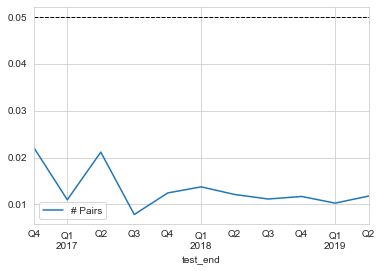

In [25]:
ax = test_results.groupby('test_end').coint.mean().to_frame('# Pairs').plot()
ax.axhline(.05, lw=1, ls='--', c='k');

### Select Candidate Pairs

In [26]:
def select_candidate_pairs(data):
    candidates = data[data.joh_sig | data.eg_sig]
    candidates['y'] = candidates.apply(lambda x: x.s1 if x.s1_dep else x.s2, axis=1)
    candidates['x'] = candidates.apply(lambda x: x.s2 if x.s1_dep else x.s1, axis=1)
    return candidates.drop(['s1_dep', 's1', 's2'], axis=1)

In [27]:
candidates = select_candidate_pairs(test_results)

In [28]:
candidates.to_hdf('backtest.h5', 'candidates')

In [29]:
candidates = pd.read_hdf('backtest.h5', 'candidates')
candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33661 entries, 7 to 23906
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   test_end  33661 non-null  datetime64[ns]
 1   w1        33661 non-null  float64       
 2   w2        33661 non-null  float64       
 3   joh_sig   33661 non-null  bool          
 4   eg        33661 non-null  float64       
 5   eg_sig    33661 non-null  bool          
 6   coint     33661 non-null  bool          
 7   y         33661 non-null  object        
 8   x         33661 non-null  object        
dtypes: bool(3), datetime64[ns](1), float64(3), object(2)
memory usage: 1.9+ MB


#### # Candidates over Time

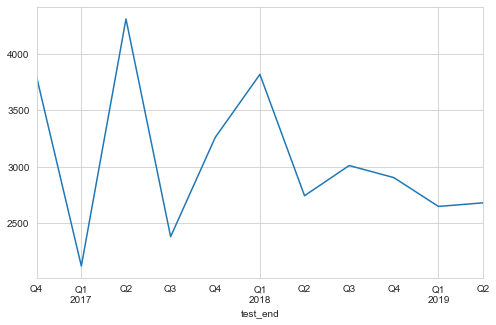

In [30]:
candidates.groupby('test_end').size().plot(figsize=(8, 5))

#### Most Common Pairs 

In [31]:
with pd.HDFStore('data.h5') as store:
    print(store.info())
    tickers = store['tickers']

<class 'pandas.io.pytables.HDFStore'>
File path: data.h5
/etfs/close              frame        (shape->[2516,139])
/stocks/close            frame        (shape->[2516,172])
/tickers                 series       (shape->[1])       


In [32]:
with pd.HDFStore('backtest.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: backtest.h5
/candidates                    frame        (shape->[33661,9])  
/cointegration_test            frame        (shape->[262988,11])


In [33]:
counter = Counter()
for s1, s2 in zip(candidates[candidates.joh_sig & candidates.eg_sig].y, 
                  candidates[candidates.joh_sig & candidates.eg_sig].x):
    if s1 > s2:
        counter[(s2, s1)] += 1
    else: 
        counter[(s1, s2)] += 1

In [34]:
most_common_pairs = pd.DataFrame(counter.most_common(10))
most_common_pairs = pd.DataFrame(most_common_pairs[0].values.tolist(), columns=['s1', 's2'])
most_common_pairs

,s1,s2
0,T.US,VOX.US
1,FXF.US,MDLZ.US
2,FXF.US,NOV.US
3,FXF.US,RIG.US
4,AMJ.US,MDLZ.US
5,DIG.US,MDLZ.US
6,DJP.US,MDLZ.US
7,ERX.US,MDLZ.US
8,FXN.US,MDLZ.US
9,IYE.US,MDLZ.US


In [59]:
with pd.HDFStore('backtest.h5') as store:
    prices = store['prices'].close.unstack('ticker').ffill(limit=5)
    tickers = store['tickers'].to_dict()

In [60]:
cnt = pd.Series(counter).reset_index()
cnt.columns = ['s1', 's2', 'n']
cnt['name1'] = cnt.s1.map(tickers)
cnt['name2'] = cnt.s2.map(tickers)
cnt.nlargest(10, columns='n')

,s1,s2,n,name1,name2
1352,T.US,VOX.US,6,AT&T,VANGUARD COMMUNICATION SERVICES ETF
384,FXF.US,MDLZ.US,5,INVESCO CURRENCYSHARES SWISS FRANC TRUST,MONDELEZ INT
388,FXF.US,NOV.US,5,INVESCO CURRENCYSHARES SWISS FRANC TRUST,NATIONAL OILWELL VARCO
391,FXF.US,RIG.US,5,INVESCO CURRENCYSHARES SWISS FRANC TRUST,TRANSOCEAN
532,AMJ.US,MDLZ.US,5,JPMORGAN ALERIAN MLP INDEX ETN,MONDELEZ INT
547,DIG.US,MDLZ.US,5,PROSHARES ULTRA OIL & GAS,MONDELEZ INT
549,DJP.US,MDLZ.US,5,IPATH BLOOMBERG COMMODITY INDEX TR ETN,MONDELEZ INT
571,ERX.US,MDLZ.US,5,DIREXION DAILY ENERGY BULL 2X SHARES,MONDELEZ INT
630,FXN.US,MDLZ.US,5,FIRST TRUST ENERGY ALPHADEX FUND,MONDELEZ INT
644,IYE.US,MDLZ.US,5,ISHARES US ENERGY ETF,MONDELEZ INT


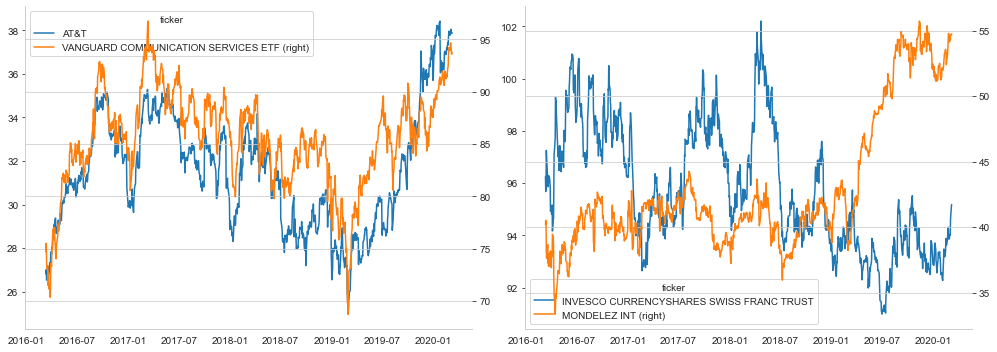

In [63]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
for i in [0, 1]:
    s1, s2 = most_common_pairs.at[i, 's1'], most_common_pairs.at[i, 's2']
    prices.loc[:, [s1, s2]].rename(columns=tickers).plot(secondary_y=tickers[s2],
                                                         ax=axes[i],
                                                         rot=0)
    axes[i].grid(False)
    axes[i].set_xlabel('')

sns.despine()
fig.tight_layout()

## Get Entry and Exit Dates 

### Smooth prices using Kalman filter

In [64]:
def KFSmoother(prices):
    """Estimate rolling mean"""
    
    kf = KalmanFilter(transition_matrices=np.eye(1),
                      observation_matrices=np.eye(1),
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=.05)

    state_means, _ = kf.filter(prices.values)
    return pd.Series(state_means.flatten(),
                     index=prices.index)

In [65]:
smoothed_prices = prices.apply(KFSmoother)
smoothed_prices.to_hdf('tmp.h5', 'smoothed')

In [66]:
smoothed_prices = pd.read_hdf('tmp.h5', 'smoothed')

### Compute rolling hedge ratio using Kalman Filter

In [67]:
def KFHedgeRatio(x, y):
    """Estimate Hedge Ratio"""
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    state_means, _ = kf.filter(y.values)
    return -state_means

### Estimate mean reversion half life

In [68]:
def estimate_half_life(spread):
    X = spread.shift().iloc[1:].to_frame().assign(const=1)
    y = spread.diff().iloc[1:]
    beta = (np.linalg.inv(X.T @ X) @ X.T @ y).iloc[0]
    halflife = int(round(-np.log(2) / beta, 0))
    return max(halflife, 1)

### Compute Spread & Bollinger Bands

In [69]:
def get_spread(candidates, prices):
    pairs = []
    half_lives = []

    periods = pd.DatetimeIndex(sorted(candidates.test_end.unique()))
    start = time()
    for p, test_end in enumerate(periods, 1):
        start_iteration = time()

        period_candidates = candidates.loc[candidates.test_end == test_end, ['y', 'x']]
        trading_start = test_end + pd.DateOffset(days=1)
        t = trading_start - pd.DateOffset(years=2)
        T = trading_start + pd.DateOffset(months=6) - pd.DateOffset(days=1)
        max_window = len(prices.loc[t: test_end].index)
        print(test_end.date(), len(period_candidates))
        for i, (y, x) in enumerate(zip(period_candidates.y, period_candidates.x), 1):
            if i % 1000 == 0:
                msg = f'{i:5.0f} | {time() - start_iteration:7.1f} | {time() - start:10.1f}'
                print(msg)
            pair = prices.loc[t: T, [y, x]]
            pair['hedge_ratio'] = KFHedgeRatio(y=KFSmoother(prices.loc[t: T, y]),
                                               x=KFSmoother(prices.loc[t: T, x]))[:, 0]
            pair['spread'] = pair[y].add(pair[x].mul(pair.hedge_ratio))
            half_life = estimate_half_life(pair.spread.loc[t: test_end])                

            spread = pair.spread.rolling(window=min(2 * half_life, max_window))
            pair['z_score'] = pair.spread.sub(spread.mean()).div(spread.std())
            pairs.append(pair.loc[trading_start: T].assign(s1=y, s2=x, period=p, pair=i).drop([x, y], axis=1))

            half_lives.append([test_end, y, x, half_life])
    return pairs, half_lives

In [70]:
candidates = pd.read_hdf('backtest.h5', 'candidates')
candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33661 entries, 7 to 23906
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   test_end  33661 non-null  datetime64[ns]
 1   w1        33661 non-null  float64       
 2   w2        33661 non-null  float64       
 3   joh_sig   33661 non-null  bool          
 4   eg        33661 non-null  float64       
 5   eg_sig    33661 non-null  bool          
 6   coint     33661 non-null  bool          
 7   y         33661 non-null  object        
 8   x         33661 non-null  object        
dtypes: bool(3), datetime64[ns](1), float64(3), object(2)
memory usage: 1.9+ MB


In [71]:
pairs, half_lives = get_spread(candidates, smoothed_prices)

2016-12-31 3793
 1000 |   180.5 |      180.5
 2000 |   360.7 |      360.7
 3000 |   536.6 |      536.6
2017-03-31 2118
 1000 |   206.2 |      883.1
 2000 |   415.7 |     1092.6
2017-06-30 4311
 1000 |   244.6 |     1363.1
 2000 |   486.8 |     1605.3
 3000 |   750.6 |     1869.1
 4000 |   989.5 |     2108.0
2017-09-30 2379
 1000 |   271.5 |     2481.2
 2000 |   538.0 |     2747.7
2017-12-31 3260
 1000 |   706.0 |     3554.9
 2000 |  2552.6 |     5401.5
 3000 |  2927.6 |     5776.4
2018-03-31 3819
 1000 |   354.2 |     6228.5
 2000 |   652.1 |     6526.5
 3000 |   954.5 |     6828.9
2018-06-30 2742
 1000 |   299.7 |     7372.7
 2000 |   595.4 |     7668.4
2018-09-30 3010
 1000 |   292.7 |     8182.6
 2000 |   588.5 |     8478.3
 3000 |   883.9 |     8773.7
2018-12-31 2903
 1000 |   292.5 |     9069.4
 2000 |   582.5 |     9359.4
2019-03-31 2647
 1000 |   295.1 |     9920.7
 2000 |   588.3 |    10213.9
2019-06-30 2679
 1000 |   290.2 |    10693.5
 2000 |   585.2 |    10988.6


### Collect Results

#### Half Lives

In [72]:
hl = pd.DataFrame(half_lives, columns=['test_end', 's1', 's2', 'half_life'])
hl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33661 entries, 0 to 33660
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   test_end   33661 non-null  datetime64[ns]
 1   s1         33661 non-null  object        
 2   s2         33661 non-null  object        
 3   half_life  33661 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.0+ MB


In [73]:
hl.half_life.describe()

count    33661.000000
mean        25.199519
std         10.223437
min          1.000000
25%         20.000000
50%         24.000000
75%         28.000000
max       1057.000000
Name: half_life, dtype: float64

In [74]:
hl.to_hdf('backtest.h5', 'half_lives')

#### Pair Data

In [75]:
pair_data = pd.concat(pairs)
pair_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4229473 entries, 2017-01-03 to 2019-12-31
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   hedge_ratio  4229473 non-null  float64
 1   spread       4229473 non-null  float64
 2   z_score      4229473 non-null  float64
 3   s1           4229473 non-null  object 
 4   s2           4229473 non-null  object 
 5   period       4229473 non-null  int64  
 6   pair         4229473 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 258.1+ MB


In [76]:
pair_data.to_hdf('backtest.h5', 'pair_data')

In [77]:
pair_data = pd.read_hdf('backtest.h5', 'pair_data')

### Identify Long & Short Entry and Exit Dates

In [78]:
def get_trades(data):
    pair_trades = []
    for i, ((period, s1, s2), pair) in enumerate(data.groupby(['period', 's1', 's2']), 1):
        if i % 100 == 0:
            print(i)

        first3m = pair.first('3M').index
        last3m = pair.last('3M').index

        entry = pair.z_score.abs() > 2
        entry = ((entry.shift() != entry)
                 .mul(np.sign(pair.z_score))
                 .fillna(0)
                 .astype(int)
                 .sub(2))

        exit = (np.sign(pair.z_score.shift().fillna(method='bfill'))
                != np.sign(pair.z_score)).astype(int) - 1

        trades = (entry[entry != -2].append(exit[exit == 0])
                  .to_frame('side')
                  .sort_values(['date', 'side'])
                  .squeeze())
        if not isinstance(trades, pd.Series):
            continue
        try:
            trades.loc[trades < 0] += 2
        except:
            print(type(trades))
            print(trades)
            print(pair.z_score.describe())
            break

        trades = trades[trades.abs().shift() != trades.abs()]
        window = trades.loc[first3m.min():first3m.max()]
        extra = trades.loc[last3m.min():last3m.max()]
        n = len(trades)

        if window.iloc[0] == 0:
            if n > 1:
                print('shift')
                window = window.iloc[1:]
        if window.iloc[-1] != 0:
            extra_exits = extra[extra == 0].head(1)
            if extra_exits.empty:
                continue
            else:
                window = window.append(extra_exits)

        trades = pair[['s1', 's2', 'hedge_ratio', 'period', 'pair']].join(window.to_frame('side'), how='right')
        trades.loc[trades.side == 0, 'hedge_ratio'] = np.nan
        trades.hedge_ratio = trades.hedge_ratio.ffill()
        pair_trades.append(trades)
    return pair_trades

In [79]:
pair_trades = get_trades(pair_data)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [80]:
pair_trade_data = pd.concat(pair_trades)
pair_trade_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134450 entries, 2017-01-03 to 2019-10-04
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   s1           134450 non-null  object 
 1   s2           134450 non-null  object 
 2   hedge_ratio  134450 non-null  float64
 3   period       134450 non-null  int64  
 4   pair         134450 non-null  int64  
 5   side         134450 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 7.2+ MB


In [81]:
pair_trade_data.head()

,s1,s2,hedge_ratio,period,pair,side
date,,,,,,
2017-01-03,AA.US,ACWI.US,-0.533861,1,16,-1
2017-01-12,AA.US,ACWI.US,-0.533861,1,16,0
2017-01-03,AA.US,ACWX.US,-0.799916,1,54,-1
2017-01-12,AA.US,ACWX.US,-0.799916,1,54,0
2017-01-03,AA.US,DEM.US,-0.896395,1,376,-1


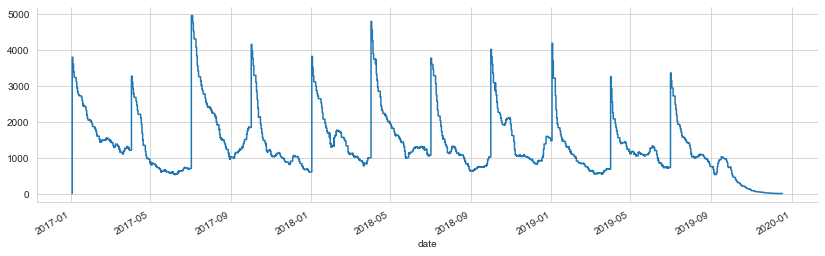

In [84]:
trades = pair_trade_data['side'].copy()
trades.loc[trades != 0] = 1
trades.loc[trades == 0] = -1
trades.sort_index().cumsum().plot(figsize=(14, 4))
sns.despine()

In [83]:
pair_trade_data.to_hdf('backtest.h5', 'pair_trades')

# Pair Trading: Backtest with Backtrader

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import csv
from collections import defaultdict
from dataclasses import dataclass, asdict
from datetime import date
from pathlib import Path
from time import time

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

In [3]:

sns.set_style('dark')
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
idx = pd.IndexSlice

In [4]:
STORE = 'backtest.h5'

In [5]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Pairs Trading Backtest

### Pairs DataClass

In [6]:
@dataclass
class Pair:
    period: int
    s1: str
    s2: str
    size1: float
    size2: float
    long: bool
    hr: float
    p1: float
    p2: float
    pos1: float
    pos2: float
    exec1: bool = False
    exec2: bool = False
    active: bool = False
    entry_date: date = None
    exit_date: date = None
    entry_spread: float = np.nan
    exit_spread: float = np.nan

    def executed(self):
        return self.exec1 and self.exec2

    def get_constituent(self, name):
        if name == self.s1:
            return 1
        elif name == self.s2:
            return 2
        else:
            return 0

    def compute_spread(self, p1, p2):
        return p1 * self.size1 + p2 * self.size2

    def compute_spread_return(self, p1, p2):
        current_spread = self.compute_spread(p1, p2)
        delta = self.entry_spread - current_spread
        return (delta / (np.sign(self.entry_spread) *
                         self.entry_spread))

### PandasData definition

In [7]:
class CustomData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = ['open', 'high', 'low', 'close', 'volume']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Define Trading Strategy

In [8]:
class StatisticalArbitrageCointegration(bt.Strategy):
    params = (('trades', None),
              ('risk_limit', -.2),
              ('verbose', True),
              ('log_file', 'backtest.csv'))

    def __init__(self):
        self.active_pairs = {}
        self.closing_pairs = {}
        self.exposure = []
        self.metrics = []
        self.last_close = {}
        self.cnt = 0
        self.today = None
        self.clear_log()
        self.order_status = dict(enumerate(['Created', 'Submitted', 'Accepted',
                                            'Partial', 'Completed', 'Canceled',
                                            'Expired', 'Margin', 'Rejected']))

    def clear_log(self):
        if Path(self.p.log_file).exists():
            Path(self.p.log_file).unlink()
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow(
                    ['Date', 'Pair', 'Symbol', 'Order #', 'Reason',
                     'Status', 'Long', 'Price', 'Size', 'Position'])

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.date()] + txt.split(','))

    def get_pair_id(self, s1, s2, period):
        return f'{s1}.{s2}.{period}'

    def check_risk_limit(self):
        for pair_id, pair in list(self.active_pairs.items()):
            if pair.active:
                p1 = self.last_close.get(pair.s1)
                p2 = self.last_close.get(pair.s2)
                ret = pair.compute_spread_return(p1, p2)
                if ret < self.p.risk_limit:
                    self.log(f'{pair_id},{pair.s1},{pair.s2},Risk Limit,{ret},')
                    del self.active_pairs[pair_id]
                    self.sell_pair(pair_id, pair)

    def sell_pair(self, pair_id, pair, reason='close'):
        info = {'pair': pair_id, 'type': reason}
        if pair.long:
            o1 = self.sell(data=pair.s1, size=abs(pair.size1), info=info)
            o2 = self.buy(data=pair.s2, size=abs(pair.size2), info=info)
        else:
            o1 = self.buy(data=pair.s1, size=abs(pair.size1), info=info)
            o2 = self.sell(data=pair.s2, size=abs(pair.size2), info=info)
        pair.active = False
        pair.exec1 = pair.exec2 = False
        self.closing_pairs[pair_id] = pair

        self.log(f'{pair_id},{pair.s1},{o1.ref},{reason},Created,{pair.long},,{pair.size1},')
        self.log(f'{pair_id},{pair.s2},{o2.ref},{reason},Created,{pair.long},,{pair.size2},')

    def notify_order(self, order):
        symbol = order.data._name
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            p = order.executed.price
            s = order.executed.size
            order_type = order.info.info['type']
            if order_type in ['open', 'close']:
                pair_id = order.info.info['pair']
                if order_type == 'open':
                    pair = self.active_pairs.get(pair_id)
                else:
                    pair = self.closing_pairs.get(pair_id)
                if pair is None:
                    self.log(f'{pair_id},{symbol},{order.ref},{order_type},Completed (missing),,{p},{s},{p * s}')
                    return
                component = pair.get_constituent(symbol)
                if component == 1:
                    pair.p1 = p
                    pair.exec1 = True
                elif component == 2:
                    pair.p2 = p
                    pair.exec2 = True
                if pair.executed():
                    pair.exec1 = False
                    pair.exec2 = False
                    if order_type == 'open':
                        pair.entry_spread = pair.compute_spread(p1=pair.p1, p2=pair.p2)
                        pair.entry_date = self.today
                        pair.active = True
                    elif order_type == 'close':
                        pair.exit_spread = pair.compute_spread(p1=pair.p1, p2=pair.p2)
                        pair.exit_date = self.today
                        pair.active = False
                        self.closing_pairs.pop(pair_id)
                self.log(f'{pair_id},{symbol},{order.ref},{order_type},Completed,{pair.long},{p},{s},{p * s}')
            else:
                self.log(f',{symbol},{order.ref},{order_type},Completed,,{p},{s},{p * s}')

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            order_type = order.info.info['type']
            self.log(f',{symbol},{order.ref},{order_type},{self.order_status[order.status]},,,,')

    def enter_pairs(self, df, long=True):
        for s1, s2, hr, period in zip(df.s1, df.s2, df.hedge_ratio, df.period):
            pair_id = self.get_pair_id(s1, s2, period)
            if self.active_pairs.get(pair_id):
                continue

            p1 = self.last_close[s1]
            p2 = self.last_close[s2]
            if long:
                size1 = self.target_value / p1
                size2 = hr * size1
            else:
                size2 = self.target_value / p2
                size1 = 1 / hr * size2

            pair = Pair(s1=s1, s2=s2, period=period, size1=size1, size2=size2,
                        pos1=p1 * size1, pos2=p2 * size2,
                        hr=hr, long=long, p1=p1, p2=p2, entry_date=self.today)
            info = {'pair': pair_id, 'type': 'open'}
            if long:
                o1 = self.buy(data=s1, size=size1, info=info)
                o2 = self.sell(data=s2, size=abs(size2), info=info)
            else:
                o1 = self.sell(data=pair.s1, size=abs(pair.size1), info=info)
                o2 = self.buy(data=pair.s2, size=abs(pair.size2), info=info)

            self.active_pairs[pair_id] = pair

            self.log(f'{pair_id},{s1},{o1.ref},Open,Created,{long},{p1},{size1},{pair.pos1}')
            self.log(f'{pair_id},{s2},{o2.ref},Open,Created,{long},{p2},{size2},{pair.pos2}')

    def adjust_pairs(self):
        orders = defaultdict(float)
        pairs = defaultdict(list)
        for pair_id, pair in self.active_pairs.items():
            p1, p2 = self.last_close[pair.s1], self.last_close[pair.s2]
            pos1, pos2 = pair.size1 * p1, pair.size2 * p2

            if pair.long:
                target_size1 = self.target_value / p1
                orders[pair.s1] += target_size1 - pair.size1
                target_size2 = pos2 / pos1 * self.target_value / p2
                orders[pair.s2] += target_size2 - pair.size2
            else:
                target_size2 = self.target_value / p2
                orders[pair.s2] += target_size2 - pair.size2
                target_size1 = pos1 / pos2 * self.target_value / p1
                orders[pair.s1] += target_size1 - pair.size1
            pair.size1 = target_size1
            pair.size2 = target_size2
            pairs[pair.s1].append(pair_id)
            pairs[pair.s2].append(pair_id)

        for symbol, size in orders.items():
            info = {'pairs': pairs[symbol], 'type': 'adjust'}
            if size > 0:
                order = self.buy(symbol, size=size, info=info)
            elif size < 0:
                order = self.sell(symbol, size=abs(size), info=info)
            else:
                continue
            self.log(f',{symbol},{order.ref},Adjust,Created,{size}')

    def prenext(self):
        self.next()

    def next(self):
        self.today = pd.Timestamp(self.datas[0].datetime.date())
        if self.today not in self.p.trades.index:
            return
        self.cnt += 1

        pf = self.broker.get_value()
        cash = self.broker.get_cash()

        exp = {d._name: pos.size for d, pos in self.getpositions().items() if pos}
        self.last_close = {d._name: d.close[0] for d in self.datas}
        exposure = pd.DataFrame({'price'   : pd.Series(self.last_close),
                                 'position': pd.Series(exp)}).replace(0, np.nan).dropna()
        exposure['value'] = exposure.price * exposure.position
        positions = exposure.value.to_dict()
        positions['date'] = self.today
        positions['cash'] = cash
        if not exposure.empty:
            self.exposure.append(positions)
            long_pos = exposure[exposure.value > 0].value.sum()
            short_pos = exposure[exposure.value < 0].value.sum()
            for symbol, row in exposure.iterrows():
                self.log(f',{symbol},,Positions,Log,,{row.price},{row.position},{row.value}')
        else:
            long_pos = short_pos = 0

        trades = self.p.trades.loc[self.today]
        if isinstance(trades, pd.Series):
            trades = trades.to_frame().T

        close = trades[trades.side == 0].sort_values('period')
        for s1, s2, period in zip(close.s1, close.s2, close.period):
            pair_id = self.get_pair_id(s1, s2, period)
            pair = self.active_pairs.pop(pair_id, None)
            if pair is None:
                self.log(f'{pair_id},,,Close Attempt,Failed,,,,')
                continue
            self.sell_pair(pair_id, pair)

        if len(self.active_pairs) > 0:
            self.check_risk_limit()

        long = trades[trades.side == 1]
        short = trades[trades.side == -1]
        if long.empty and short.empty: return
        target = 1 / (len(long) + len(short) + len(self.active_pairs))
        self.target_value = pf * target
        metrics = [self.today, pf, pf - cash, cash, len(exposure), len(self.active_pairs), long_pos, short_pos,
                   target, self.target_value, len(long), len(short), len(close)]
        self.metrics.append(metrics)
        if self.cnt % 21 == 0:
            holdings = pf - cash
            msg = f'PF: {pf:11,.0f} | Net: {holdings: 11,.0f} | # Pos: {len(exposure):3,.0f} | # Pairs: {len(self.active_pairs):3,.0f} | '
            msg += f'Long: {long_pos: 10,.0f} | Short: {short_pos: 10,.0f}'
            print(self.today, msg)

        self.adjust_pairs()

        if not long.empty:
            self.enter_pairs(long, long=True)

        if not short.empty:
            self.enter_pairs(short, long=False)

### Load Trades

In [9]:
trades = pd.read_hdf(STORE, 'pair_trades').sort_index()
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134450 entries, 2017-01-03 to 2019-12-18
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   s1           134450 non-null  object 
 1   s2           134450 non-null  object 
 2   hedge_ratio  134450 non-null  float64
 3   period       134450 non-null  int64  
 4   pair         134450 non-null  int64  
 5   side         134450 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 7.2+ MB


In [10]:
trade_dates = np.unique(trades.index)
start = trade_dates.min()
end = trade_dates.max()
traded_symbols = trades.s1.append(trades.s2).unique()

### Load Prices

In [11]:
prices = (pd.read_hdf(STORE, 'prices')
          .sort_index()
          .loc[idx[traded_symbols, str(start):str(end)], :])

In [12]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 232003 entries, ('AA.US', Timestamp('2017-01-03 00:00:00')) to ('GS.US', Timestamp('2019-12-18 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    232003 non-null  float64
 1   high    232003 non-null  float64
 2   low     232003 non-null  float64
 3   close   232003 non-null  float64
 4   volume  232003 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 10.2+ MB


### Configure Cerebro

In [13]:
cerebro = bt.Cerebro()
cash = 1000000
cerebro.broker.setcash(cash)

### Add Data

In [14]:
for symbol in traded_symbols:
    df = prices.loc[idx[symbol, :], :].droplevel('ticker', axis=0)
    df.index.name = 'datetime'
    bt_data = CustomData(dataname=df)
    cerebro.adddata(bt_data, name=symbol)

### Add Strategy & Analyzer

In [15]:
cerebro.addstrategy(StatisticalArbitrageCointegration,
                    trades=trades, verbose=True,
                    log_file='bt_log.csv')

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

### Run Strategy

In [16]:
start = time()
results = cerebro.run()

ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f} | Duration: {format_time(duration)}')

2017-02-01 00:00:00 PF:   1,004,229 | Net:      33,384 | # Pos: 275 | # Pairs: 265 | Long:    780,496 | Short:   -747,113
2017-03-03 00:00:00 PF:   1,028,845 | Net:      55,858 | # Pos: 280 | # Pairs: 235 | Long:    779,003 | Short:   -723,145
2017-04-03 00:00:00 PF:   1,029,713 | Net:      64,817 | # Pos: 292 | # Pairs: 689 | Long:    813,349 | Short:   -748,532
2017-05-03 00:00:00 PF:   1,036,655 | Net:      73,245 | # Pos: 299 | # Pairs: 263 | Long:    907,078 | Short:   -833,833
2017-06-02 00:00:00 PF:   1,014,250 | Net:      80,586 | # Pos: 282 | # Pairs: 218 | Long:    844,852 | Short:   -764,266
2017-07-03 00:00:00 PF:     997,286 | Net:      65,692 | # Pos: 284 | # Pairs: 161 | Long:    797,628 | Short:   -731,936
2017-08-02 00:00:00 PF:   1,031,169 | Net:      41,116 | # Pos: 307 | # Pairs: 445 | Long:    719,039 | Short:   -677,923
2017-08-31 00:00:00 PF:   1,048,305 | Net:      12,173 | # Pos: 297 | # Pairs: 123 | Long:    851,316 | Short:   -839,143
2017-10-02 00:00:00 PF: 

### Get PyFolio Inputs

In [17]:
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [18]:
returns.to_hdf(STORE, 'returns')
positions.to_hdf(STORE, 'positions')
transactions.to_hdf(STORE, 'transactions/')
gross_lev.to_hdf(STORE, 'gross_lev')

### Get Positions

The PyFolio integration is somewhat broken due to API changes after version 0.5.1 so we need to retrieve the positions manually.

In [19]:
traded_pairs = pd.DataFrame(results[0].exposure)
traded_pairs.date = pd.to_datetime(traded_pairs.date)
traded_pairs = traded_pairs.set_index('date').tz_localize('UTC')
traded_pairs.to_hdf(STORE, 'traded_pairs')
traded_pairs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 736 entries, 2017-01-04 00:00:00+00:00 to 2019-12-18 00:00:00+00:00
Columns: 312 entries, AA.US to cash
dtypes: float64(312)
memory usage: 1.8 MB


### Get Metrics

In [20]:
metrics = pd.DataFrame(results[0].metrics,
                       columns=['date', 'pf', 'net_holdings', 'cash',
                                'npositions', 'npairs', 'nlong_pos', 'nshort_pos',
                                'target', 'target_val', 'nlong_trades',
                                'nshort_trades', 'nclose_trades'])
metrics.to_hdf(STORE, 'metrics')

## Run PyFolio Analysis

In [21]:
returns = pd.read_hdf(STORE, 'returns')
transactions = pd.read_hdf(STORE, 'transactions/')
gross_lev = pd.read_hdf(STORE, 'gross_lev')
metrics = pd.read_hdf(STORE, 'metrics').set_index('date')

In [22]:
metrics.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 676 entries, 2017-01-03 to 2019-09-30
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pf             676 non-null    float64
 1   net_holdings   676 non-null    float64
 2   cash           676 non-null    float64
 3   npositions     676 non-null    int64  
 4   npairs         676 non-null    int64  
 5   nlong_pos      676 non-null    float64
 6   nshort_pos     676 non-null    float64
 7   target         676 non-null    float64
 8   target_val     676 non-null    float64
 9   nlong_trades   676 non-null    int64  
 10  nshort_trades  676 non-null    int64  
 11  nclose_trades  676 non-null    int64  
dtypes: float64(7), int64(5)
memory usage: 68.7 KB


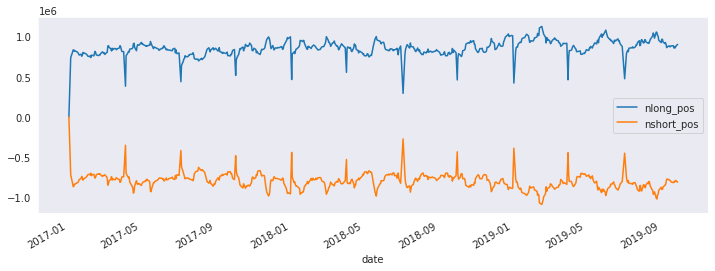

In [23]:
metrics[['nlong_pos', 'nshort_pos']].plot(figsize=(12, 4));

### Get Benchmark

In [24]:
start = str(returns.index.min().year)
end = str(returns.index.max().year + 1)

In [25]:
benchmark = web.DataReader('SP500', 'fred',
                           start=start,
                           end=end).squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

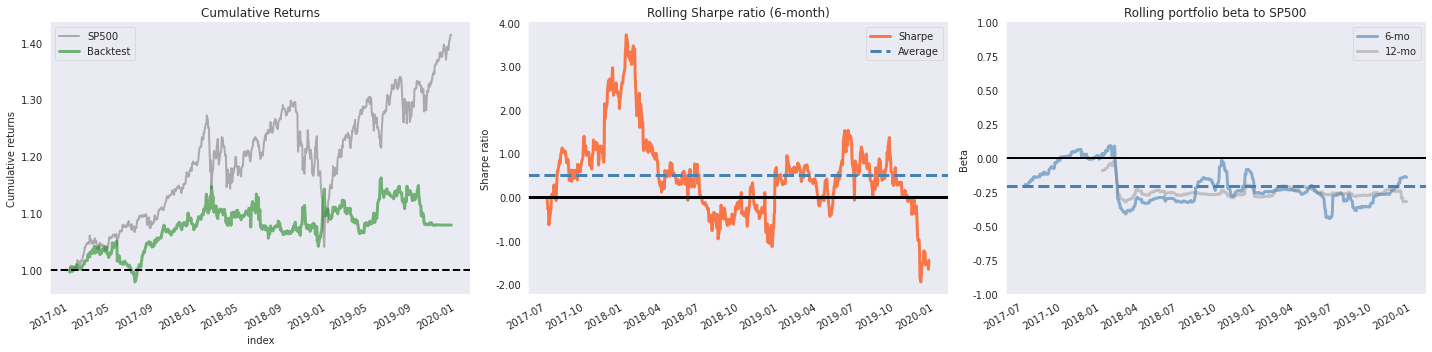

In [26]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))
pf.plotting.plot_rolling_returns( returns, factor_returns=benchmark, ax=axes[0])
axes[0].set_title('Cumulative Returns')
pf.plotting.plot_rolling_sharpe(returns, ax=axes[1])
pf.plotting.plot_rolling_beta(returns, benchmark, ax=axes[2])
sns.despine()
fig.tight_layout();

### Create full tearsheet

Start date,2017-01-03
End date,2019-12-18
Total months,35
,Backtest
Annual return,2.621%
Cumulative returns,7.961%
Annual volatility,9.304%
Sharpe ratio,0.32
Calmar ratio,0.29
Stability,0.51
Max drawdown,-9.175%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.18,2018-02-08,2018-12-07,2019-05-31,342
1,7.17,2019-06-03,2019-10-31,NaT,NaN
2,6.79,2017-05-16,2017-07-07,2017-09-01,79
3,2.92,2018-01-25,2018-01-30,2018-02-08,11
4,2.66,2017-12-04,2017-12-20,2018-01-17,33


Stress Events,mean,min,max
New Normal,0.01%,-3.83%,2.81%


Top 10 long positions of all time,max
GS.US,6.65%


Top 10 short positions of all time,max
GS.US,-10.80%


Top 10 positions of all time,max
GS.US,10.80%


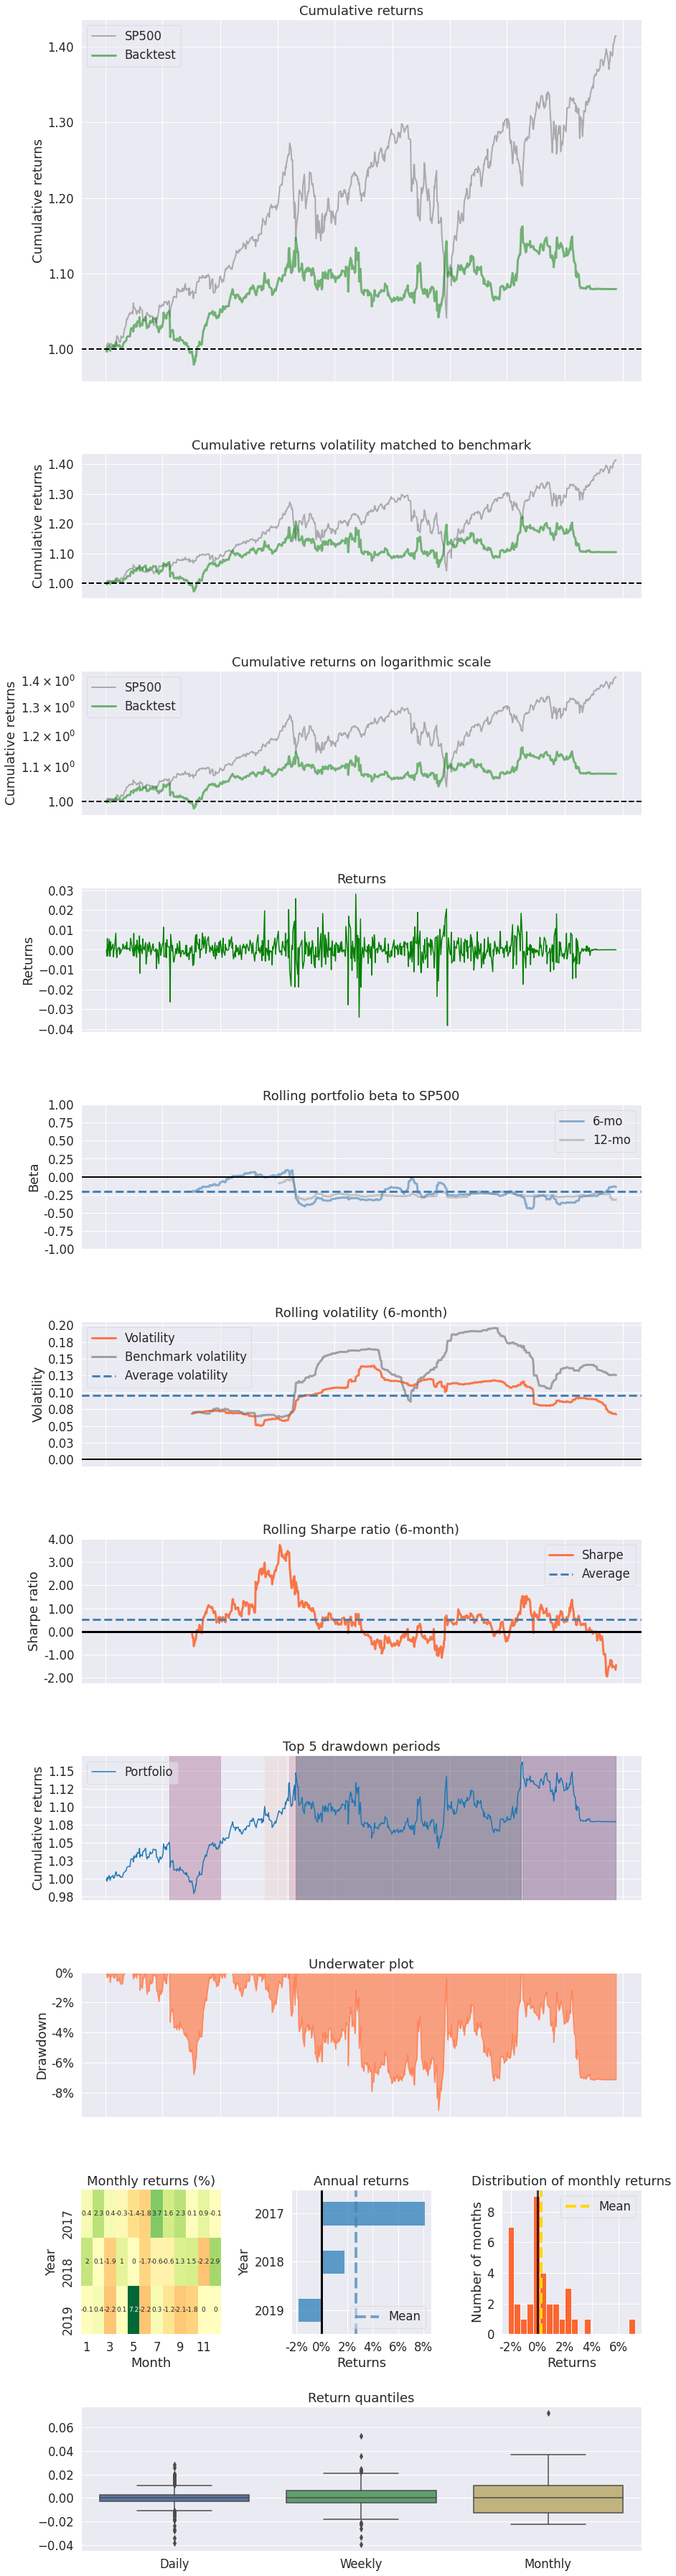

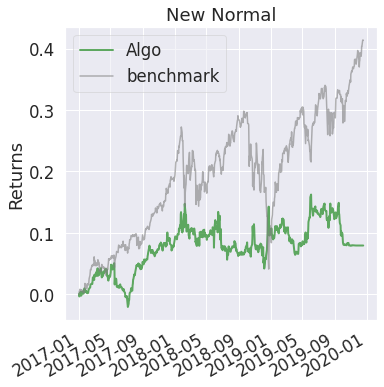

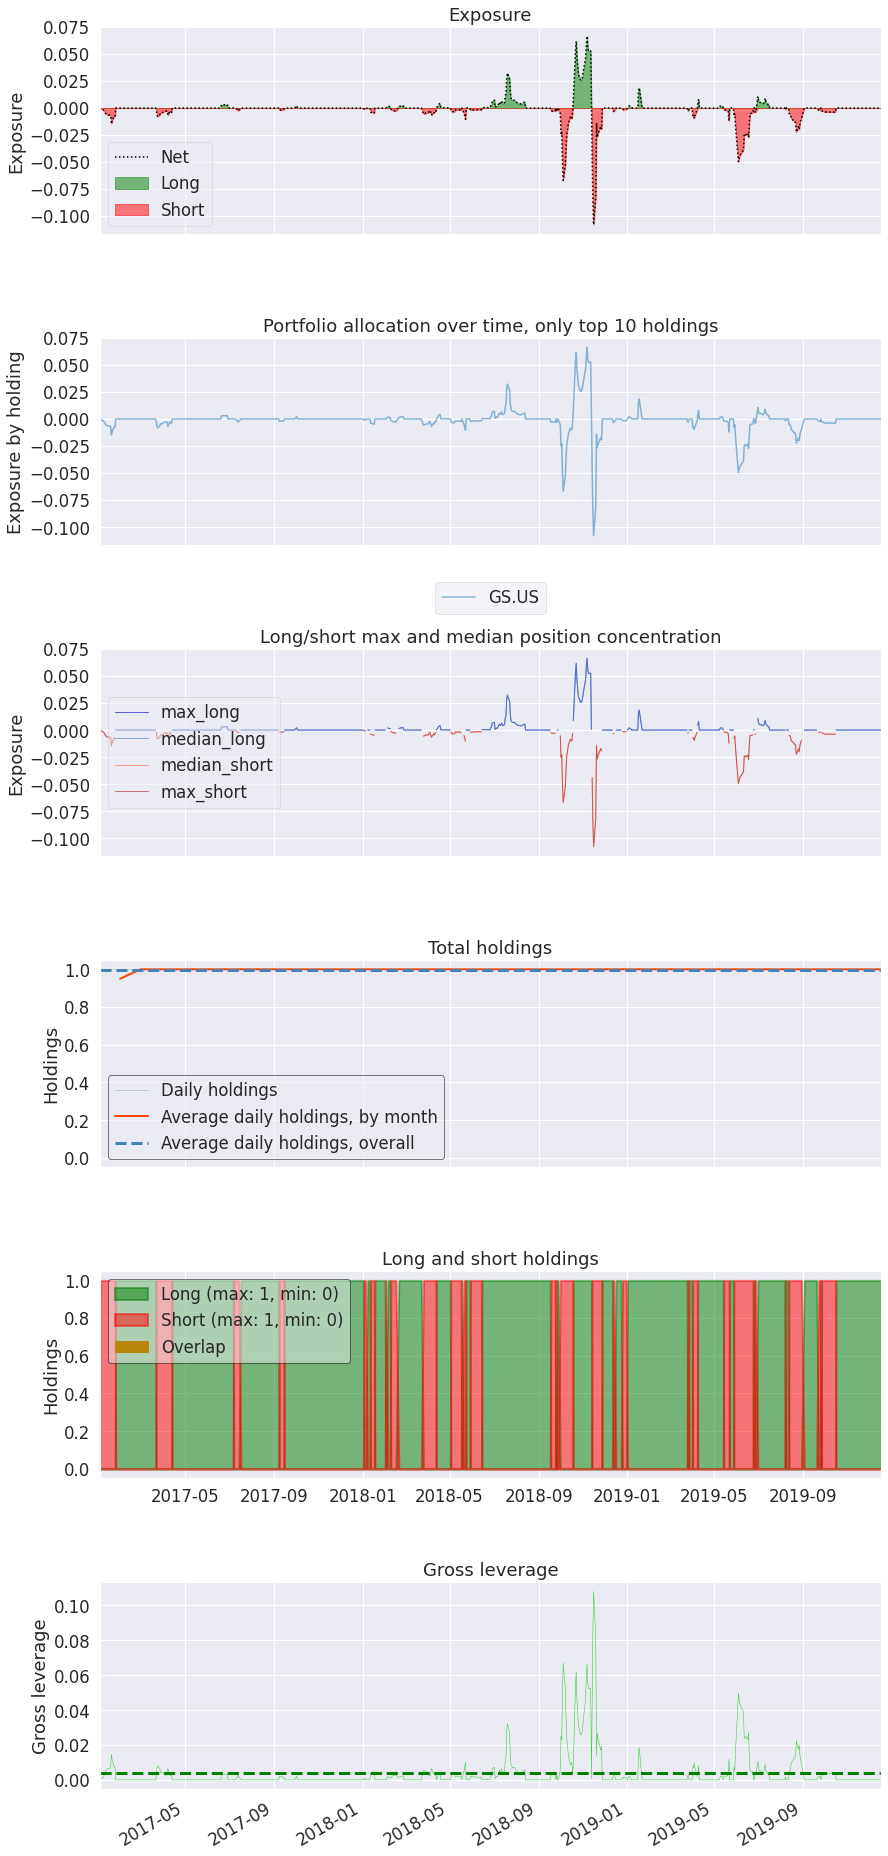

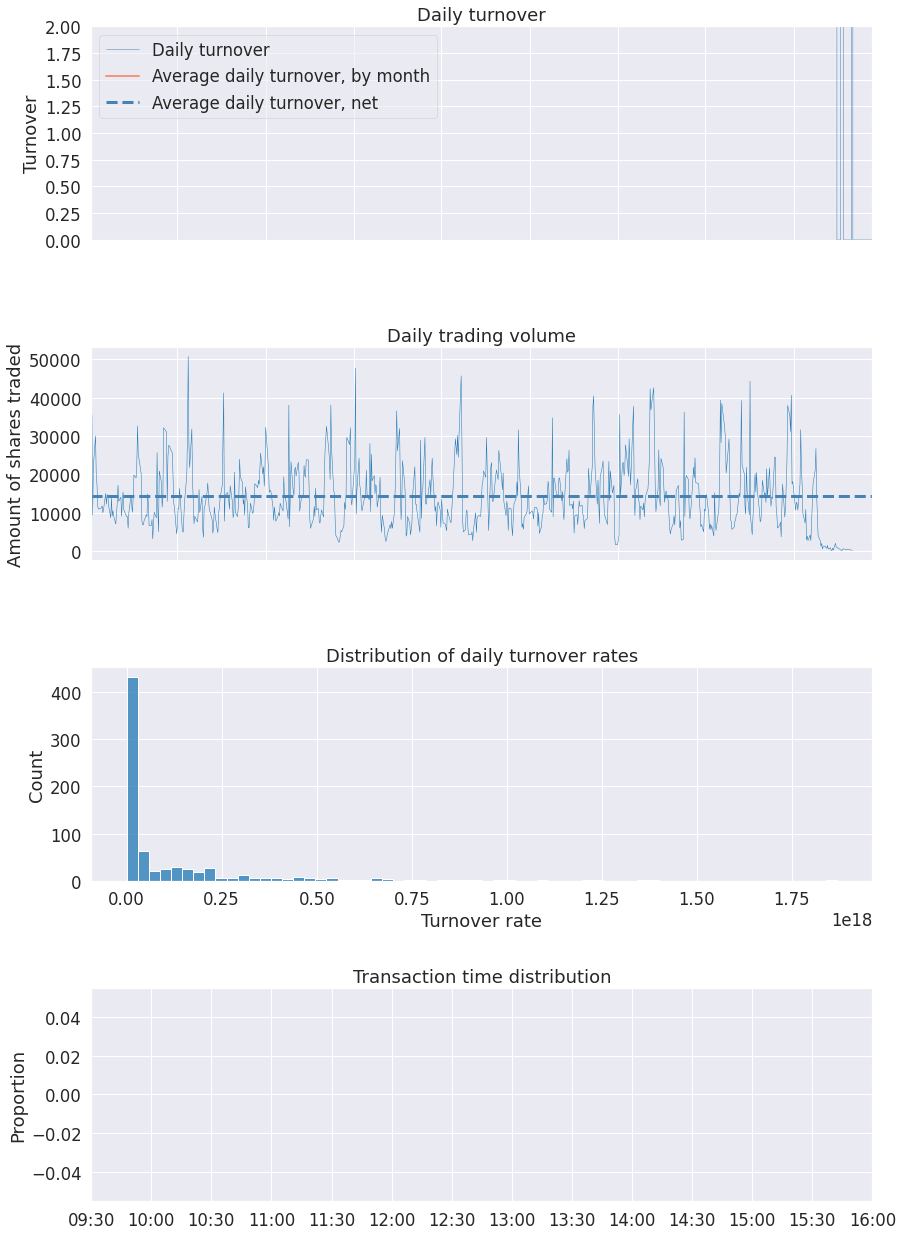

In [27]:
pf.create_full_tear_sheet(returns,
                          positions=positions,
                          transactions=transactions,
                          benchmark_rets=benchmark.loc[returns.index],
                          estimate_intraday=False)